# Final Project - Machine Learning in Practice

# Chủ đề: Classification/ Skin Cancer MNIST: HAM10000

## Nhóm thực hiện: Nhóm 3
* Tô Minh Đức - B21DCDT068
* Nguyễn Minh Đăng - B21DCVT103
* Nguyễn Trường Giang - B21DCVT168
* Nguyễn Văn Thi - B21DCCN685
* Nguyễn Thị Thu Trang - 22028254

# Cài đặt, import các thư viện và dataset

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
import imagehash
from collections import defaultdict
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# I. Exploratory Data Analysis
# 1. Giới thiệu và lựa chọn dữ liệu
## Nguồn gốc của tập dữ liệu:
* Bộ dữ liệu được lấy từ Kaggle

* Đây là tập dữ liệu mở, thường được dùng cho các nghiên cứu và bài toán học máy trong lĩnh vực chẩn đoán hình ảnh y tế, đặc biệt là phân loại ung thư da.

## Mô tả chung về bộ dữ liệu:

Bộ dữ liệu HAM10000 (Human Against Machine with 10000 training images) bao gồm hơn 10.000 hình ảnh da liễu dạng dermatoscopic cùng với thông tin metadata của bệnh nhân. Các hình ảnh này được gắn nhãn thuộc 7 loại tổn thương da khác nhau, từ lành tính đến ác tính (ung thư).

Dữ liệu có nhãn (dx) cho biết loại bệnh của mỗi ảnh, do đó bộ dữ liệu phù hợp cho các bài toán phân loại đa lớp trong học máy và deep learning, điển hình như huấn luyện mô hình CNN (Convolutional Neural Network) để tự động chẩn đoán ung thư da.

# 2. EDA for Metadata

## 2.1 Đọc dữ liệu và khám phá tổng quan

In [85]:
metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [86]:
metadata.shape

(10015, 7)

In [87]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


Missing Values  Percentage (%)
age                       57        0.569146
image_id                   0        0.000000
lesion_id                  0        0.000000
dx                         0        0.000000
dx_type                    0        0.000000
sex                        0        0.000000
localization               0        0.000000

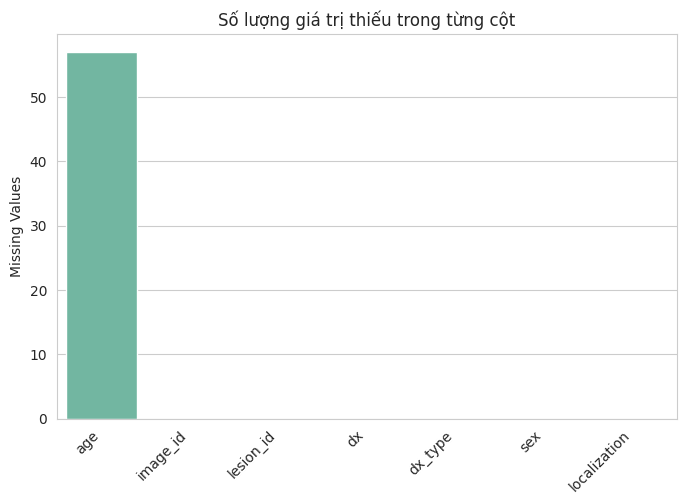

In [88]:
missing_counts = metadata.isnull().sum()
missing_perc = (missing_counts / len(metadata)) * 100
missing_df = pd.DataFrame({
    "Missing Values": missing_counts,
    "Percentage (%)": missing_perc
}).sort_values(by="Missing Values", ascending=False)

display(missing_df)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=missing_df.index,
    y="Missing Values",
    data=missing_df,
    palette="Set2"
)
plt.xticks(rotation=45, ha="right")
plt.title("Số lượng giá trị thiếu trong từng cột")
plt.show()

### Nhận xét:
- Chỉ có cột age có giá trị thiếu, với số lượng 57 giá trị, chiểm khoảng 0.57%.
- Các cột còn lại như lesion_id, image_id, dx, dx_type, sex, localization không có giá trị thiếu.

In [89]:
metadata.duplicated().sum()

0

In [90]:
metadata.nunique()

lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                18
sex                 3
localization       15
dtype: int64

## 2.2 Thông tin dataset
### Dataset gồm 7 cột, chi tiết như sau:
| Tên cột        | Ý nghĩa                                                                                           | Đơn vị | Kiểu dữ liệu | Dạng dữ liệu           |
| -------------- | ------------------------------------------------------------------------------------------------- | ------ | ------------ | ---------------------- |
| `lesion_id`    | Định danh duy nhất cho mỗi tổn thương da (cùng bệnh nhân có thể có nhiều ảnh)                     | -      | Chuỗi ký tự  | Danh mục (ID)          |
| `image_id`     | Định danh duy nhất cho mỗi ảnh da                                                                 | -      | Chuỗi ký tự  | Danh mục (ID)          |
| `dx`           | Loại bệnh được chẩn đoán (7 lớp): `akiec`, `bcc`, `bkl`, `df`, `nv`, `vasc`, `mel`                | -      | Chuỗi ký tự  | Danh mục (categorical) |
| `dx_type`      | Phương pháp chẩn đoán: `histopathology (histo)`, `follow-up (follow_up)`, `consensus`, `confocal` | -      | Chuỗi ký tự  | Danh mục (categorical) |
| `age`          | Tuổi của bệnh nhân                                                                                | Năm    | Số nguyên    | Số (numerical)         |
| `sex`          | Giới tính của bệnh nhân: `male`, `female`                                                         | -      | Chuỗi ký tự  | Danh mục (categorical) |
| `localization` | Vị trí của tổn thương trên cơ thể: ví dụ `back`, `chest`, `lower extremity`, `abdomen`, …         | -      | Chuỗi ký tự  | Danh mục (categorical) |


In [91]:
numerical_cols = ['age']
categorical_cols1 = ['dx_type', 'sex']
categorical_cols2 = ['dx_type', 'sex', 'localization']
target = 'dx'

## 2.3 Thống kê mô tả và trực quan hóa cột số

In [92]:
metadata.describe()

age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

### Nhận xét:
* Tuổi trung bình ~ 52, trung vị 50, phân bố khá cân đối.
* Phần lớn bệnh nhân trong độ tuổi 40–65.
* Tuổi tối đa 85, hợp lý với dữ liệu y tế.

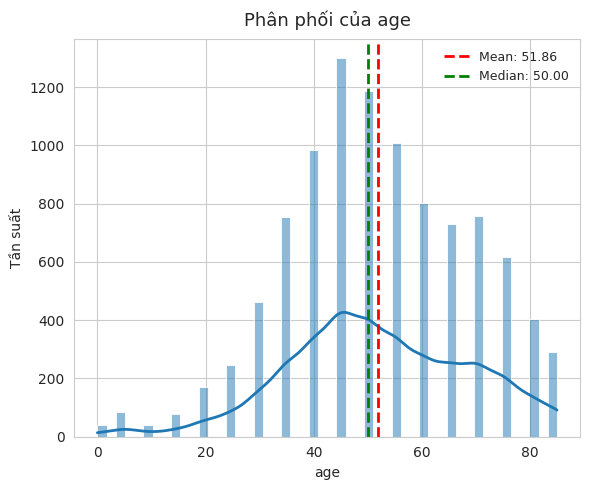

In [93]:
col = "age"

plt.figure(figsize=(6, 5))
sns.histplot(metadata[col], kde=True, bins=50, line_kws={'linewidth': 2})

plt.axvline(metadata[col].mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {metadata[col].mean():.2f}')
plt.axvline(metadata[col].median(), color='green', linestyle='dashed', linewidth=2,
            label=f'Median: {metadata[col].median():.2f}')

plt.title(f'Phân phối của {col}', fontsize=13, pad=10)
plt.xlabel(col)
plt.ylabel('Tần suất')
plt.legend(fontsize=9, loc='best', frameon=False)

plt.tight_layout()
plt.show()

### Nhận xét:
#### Hình dạng phân phối:
    - Phân phối gần như đối xứng quanh trung tâm, hơi lệch phải nhẹ.
    - Có mật độ cao nhất ở khoảng 45–55 tuổi, tức là phần lớn mẫu thuộc nhóm trung niên.
#### Thống kê cơ bản:
    - Mean (trung bình) ≈ 51.86 tuổi.
    - Median (trung vị) = 50 tuổi.
    - Mean cao hơn median một chút → tồn tại một số giá trị tuổi cao (trên 80) kéo trung bình lên.

#### Khoảng tuổi:
    - Tuổi trải rộng từ khoảng 0 đến hơn 85.
    - Các nhóm tuổi dưới 20 và trên 80 có tần suất rất thấp.
#### Ý nghĩa:
    - Tập dữ liệu tập trung vào nhóm bệnh nhân trung niên và cao tuổi, điều này phản ánh thực tế rằng các bệnh về da (như ung thư da) thường xuất hiện nhiều hơn ở độ tuổi này.
    - Khi huấn luyện mô hình, cần lưu ý rằng dữ liệu về trẻ em và người rất cao tuổi khá ít, có thể ảnh hưởng tới khả năng mô hình dự đoán chính xác cho các nhóm này.

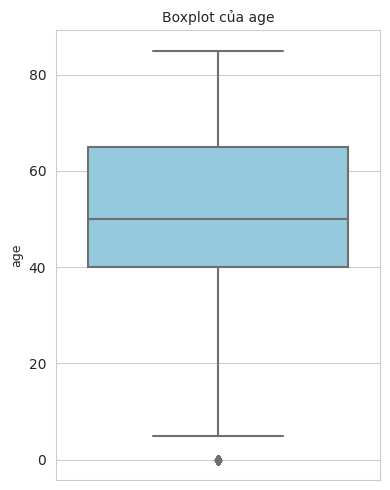

In [94]:
n_cols = 1
n_rows = len(numerical_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4, 5)) 

if n_rows == 1:
    axes = [axes]

for i, col in enumerate(numerical_cols):
    sns.boxplot(
        data=metadata,
        y=col,                
        color="skyblue",
        ax=axes[i]
    )
    axes[i].set_title(f'Boxplot của {col}', fontsize=10)
    axes[i].set_xlabel("")  
    axes[i].set_ylabel(col, fontsize=9)

plt.tight_layout()
plt.show()

### Nhận xét:
- Phần lớn bệnh nhân nằm trong khoảng từ 40 - 65 tuổi.
- Có một điểm dữ liệu bất thường ở khoảng dưới 5 tuổi (Có thể là do nhập sai dữ liệu)

In [95]:
def count_outliers_iqr(metadata, columns):
    outlier_dict = {}
    for col in columns:
        Q1 = metadata[col].quantile(0.25)
        Q3 = metadata[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outlier_count = metadata[(metadata[col] < lower) | (metadata[col] > upper)].shape[0]
        outlier_dict[col] = outlier_count
    return outlier_dict
outlier_counts = count_outliers_iqr(metadata, ['age'])
outlier_metadata = pd.DataFrame(list(outlier_counts.items()), columns=['Thuộc tính', 'Số lượng outliers'])
display(outlier_metadata)

Thuộc tính  Số lượng outliers
0        age                 39

### Nhận xét: 
Ở cột age, có 39 giá trị được xác định là outlier, tuy nhiên do tất cả đều tập trung tại cùng một mức tuổi rất nhỏ nên trên boxplot chỉ thể hiện dưới dạng một điểm ngoại lai duy nhất.


## 2.4 Thống kê mô tả và trực quan hóa cột phân loại

In [96]:
def print_categorical_summary(metadata, col):
    counts = metadata[col].value_counts()
    percents = metadata[col].value_counts(normalize=True) * 100

    summary = pd.DataFrame({
        'Số lượng': counts.values,
        'Tỷ lệ (%)': percents.round(2)
    })

    return summary

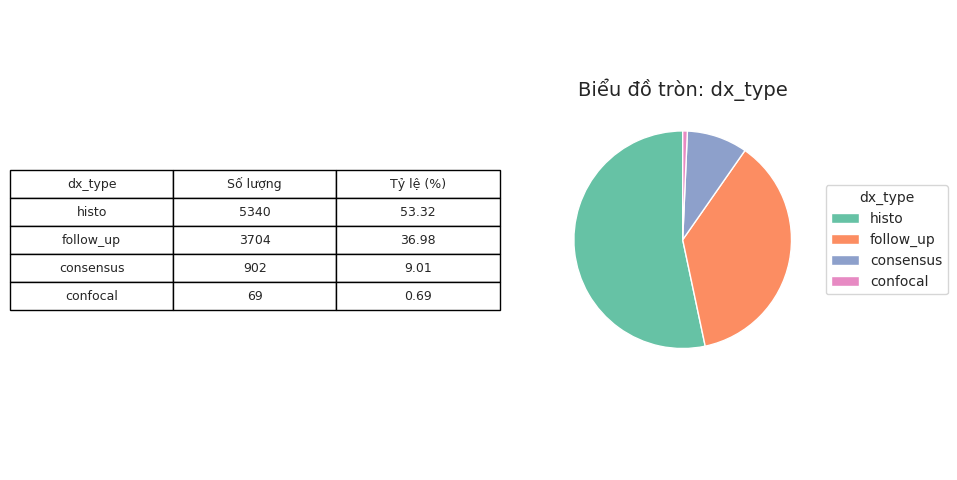

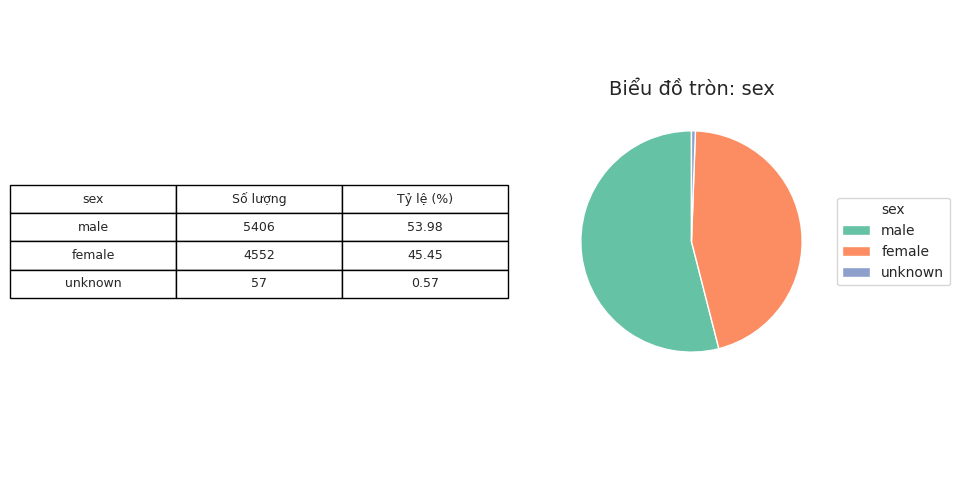

In [97]:
sns.set_style("whitegrid")

for col in categorical_cols1:
    summary = print_categorical_summary(metadata, col)

    counts = summary['Số lượng']
    labels = summary.index
    colors = sns.color_palette('Set2', len(labels))

    fig, (ax_table, ax_pie) = plt.subplots(ncols=2, figsize=(10, 5))

    ax_table.axis('off')
    table_data = summary.reset_index()
    table_data.rename(columns={table_data.columns[0]: col}, inplace=True)

    table = ax_table.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)     # giảm font
    table.scale(1.8, 1.4) 

    # ----- Biểu đồ tròn -----
    wedges, _ = ax_pie.pie(
        counts,
        colors=colors,
        startangle=90,
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )

    ax_pie.set_title(f"Biểu đồ tròn: {col}", fontsize=14)

    # Legend bên ngoài
    ax_pie.legend(
        wedges,
        labels,
        title=col,
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

Số lượng  Tỷ lệ (%)
localization                        
back                 2192      21.89
lower extremity      2077      20.74
trunk                1404      14.02
upper extremity      1118      11.16
abdomen              1022      10.20
face                  745       7.44
chest                 407       4.06
foot                  319       3.19
unknown               234       2.34
neck                  168       1.68
scalp                 128       1.28
hand                   90       0.90
ear                    56       0.56
genital                48       0.48
acral                   7       0.07

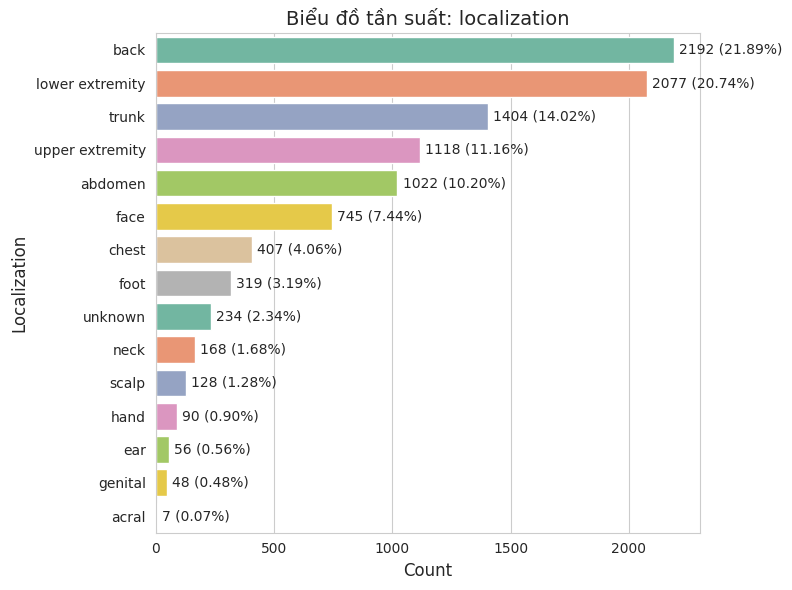

In [98]:
col = 'localization'
temp = print_categorical_summary(metadata, col)
display(temp)

sns.set_style("whitegrid")

# Sắp xếp theo tần suất giảm dần
order = temp.index.tolist()

plt.figure(figsize=(8, 6))
ax = sns.countplot(y=col, data=metadata, palette='Set2', order=order)

plt.title(f"Biểu đồ tần suất: {col}", fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel(col.capitalize(), fontsize=12)

# Thêm nhãn số lượng & %
for p, (count, percent) in zip(ax.patches, zip(temp['Số lượng'], temp['Tỷ lệ (%)'])):
    ax.text(p.get_width() + max(temp['Số lượng']) * 0.01,  # đẩy sang phải
            p.get_y() + p.get_height() / 2.,
            f'{int(count)} ({percent:.2f}%)',
            ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### Nhận xét:
#### 1. Cột dx_type:
 - Phân bố tỷ lệ
    - histo (giải phẫu bệnh) chiếm 53.32% — hơn một nửa số mẫu được xác nhận bằng tiêu chuẩn vàng (gold standard) trong chẩn đoán da liễu.
    - follow_up (theo dõi lâm sàng) chiếm 36.98% — tỷ lệ lớn thứ hai, thường được dùng khi không có xét nghiệm mô bệnh nhưng vẫn theo dõi bệnh nhân trong thời gian dài để xác nhận.
    - consensus (đồng thuận chuyên gia) chiếm 9.01% — áp dụng khi nhiều bác sĩ đồng ý về chẩn đoán dựa trên hình ảnh và triệu chứng.
    - confocal (soi hiển vi phản xạ confocal) chiếm 0.69% — rất ít mẫu, thường được dùng khi cần chẩn đoán không xâm lấn.
- Tập dữ liệu kết hợp nhiều nguồn xác nhận nhãn, trong đó giải phẫu bệnh (histo) chiếm ưu thế, đảm bảo độ tin cậy cao cho phần lớn dữ liệu.
- Việc sử dụng các phương pháp khác như follow_up và consensus cho thấy dữ liệu phản ánh được nhiều bối cảnh thực tế lâm sàng, không chỉ các trường hợp được sinh thiết mô bệnh.
- confocal xuất hiện rất ít, có thể dẫn đến thiếu dữ liệu khi model học các đặc trưng về các mẫu dùng phương pháp này. Có thể nhóm các phương pháp ít xuất hiện (consensus và confocal) thành một nhóm chung để giảm mất cân bằng dữ liệu.
#### 2. Cột sex:
- Phân bố tỉ lệ:
    - Nam (male): 5,406 mẫu (53.98%) — chiếm tỷ lệ cao hơn nữ nhưng chỉ chênh lệch khoảng 8,5%.
    - Nữ (female): 4,552 mẫu (45.45%) — tỷ lệ gần tương đương nam, cho thấy dữ liệu khá cân bằng giới tính.
    - Không rõ (unknown): 57 mẫu (0.57%) — rất nhỏ, hầu như không ảnh hưởng đến phân tích tổng quan.
- Tập dữ liệu có sự phân bố giới tính tương đối cân đối, điều này giúp giảm nguy cơ mô hình bị thiên lệch theo giới tính khi huấn luyện.
- Số lượng mẫu unknown ít, có thể giữ nguyên hoặc loại bỏ tùy mục tiêu phân tích.

#### 3. Cột localization:
- Phân bố tỷ lệ vị trí tổn thương:
    - Áp đảo nhất: Lưng (21.89%) và chi dưới (20.74%) → chiếm gần 43% toàn bộ dữ liệu.
    - Nhóm trung bình (10–15%): Thân (14.02%), chi trên (11.16%), bụng (10.20%).
    - Nhóm ít hơn (<8%): Mặt, ngực, bàn chân, vùng không xác định, cổ, da đầu.
    - Hiếm gặp (<1%): Bàn tay, tai, bộ phận sinh dục, acral.

- Nhận xét tổng quan:
    - Phân bố dữ liệu không đồng đều, với phần lớn mẫu tập trung ở vùng lưng và chi dưới.
    - Các vị trí hiếm gặp có rất ít mẫu → nguy cơ mất cân bằng dữ liệu khi huấn luyện.
    - Mô hình có thể học tốt với nhóm phổ biến, nhưng dễ dự đoán kém với nhóm hiếm, cần cân nhắc kỹ thuật xử lý dữ liệu mất cân bằng (oversampling, augmentation...).

## 2.5 Thống kê mô tả và trực quan hóa cột nhãn

Số lượng  Tỷ lệ (%)
dx                        
nv         6705      66.95
mel        1113      11.11
bkl        1099      10.97
bcc         514       5.13
akiec       327       3.27
vasc        142       1.42
df          115       1.15

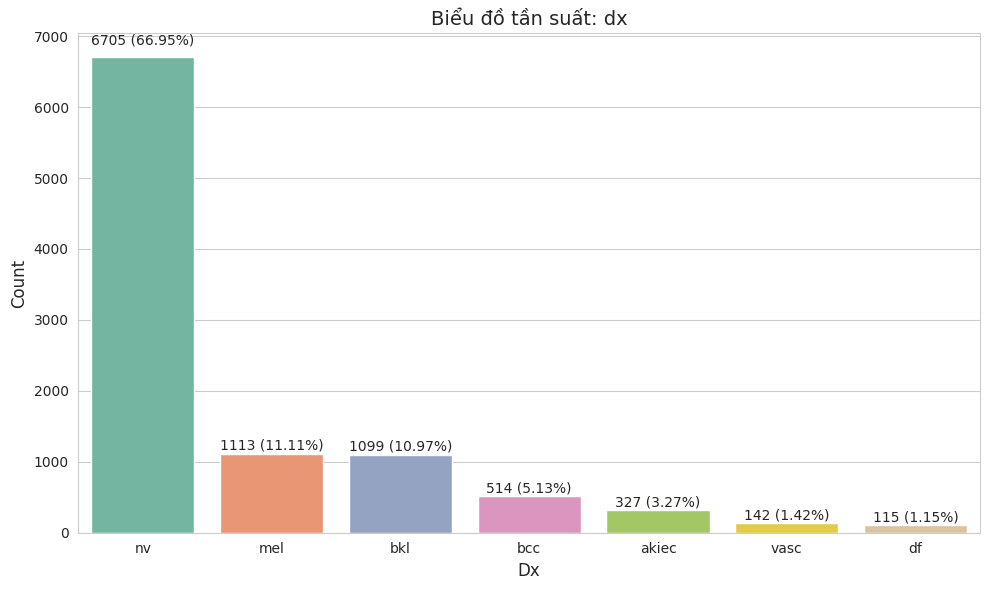

In [99]:
temp = print_categorical_summary(metadata, target)
display(temp)

sns.set_style("whitegrid")
order = temp.index.tolist()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=target, data=metadata, palette='Set2', order=order)

plt.title(f"Biểu đồ tần suất: {target}", fontsize=14)
plt.xlabel(target.capitalize(), fontsize=12)
plt.ylabel('Count', fontsize=12)

for p, (count, percent) in zip(ax.patches, zip(temp['Số lượng'], temp['Tỷ lệ (%)'])):
    ax.text(p.get_x() + p.get_width() / 2., 
            p.get_height() + p.get_height() * 0.02,
            f'{int(count)} ({percent:.2f}%)',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Nhận xét:
- Phân tích tỉ lệ
    - Áp đảo nhất: nv (melanocytic nevi – nốt ruồi sắc tố) chiếm 66.95% (6,705 mẫu).
    - Nhóm tỉ lệ trung bình:
        - mel (melanoma – ung thư hắc tố): 11.11% (1,113 mẫu).
        - bkl (benign keratosis-like lesions – tổn thương sừng lành tính): 10.97% (1,099 mẫu).
    - Nhóm ít dữ liệu:
        - bcc (basal cell carcinoma – ung thư biểu mô tế bào đáy): 5.13% (514 mẫu).
        - akiec (actinic keratoses / intraepithelial carcinoma – tiền ung thư da): 3.27% (327 mẫu).
        - vasc (vascular lesions – tổn thương mạch máu): 1.42% (142 mẫu).
        - df (dermatofibroma – u xơ da): 1.15% (115 mẫu).
- Dữ liệu bị mất cân bằng mạnh, trong đó nv nhiều gấp ~60 lần df.
- Các lớp hiếm (đặc biệt vasc và df) dễ bị mô hình bỏ qua nếu không xử lý mất cân bằng.
- Việc huấn luyện mô hình phân loại đa lớp cần chú ý kỹ chiến lược sampling để đảm bảo nhận diện được cả các bệnh hiếm 

## 2.6 Mối quan hệ giữa cột số và cột phân loại

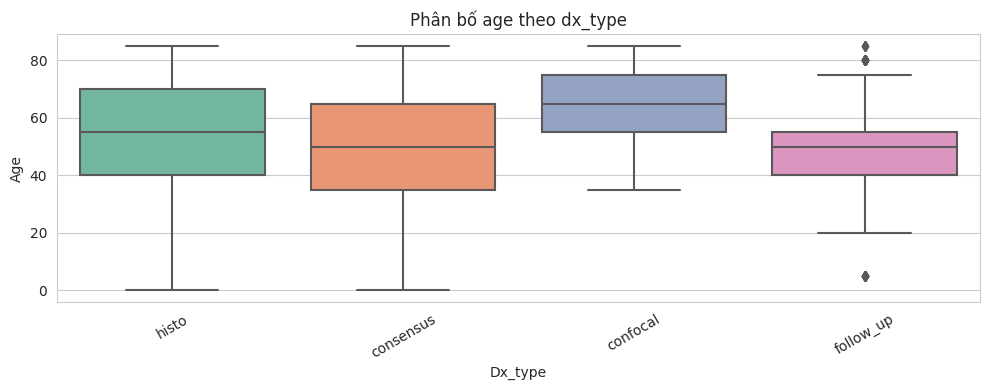

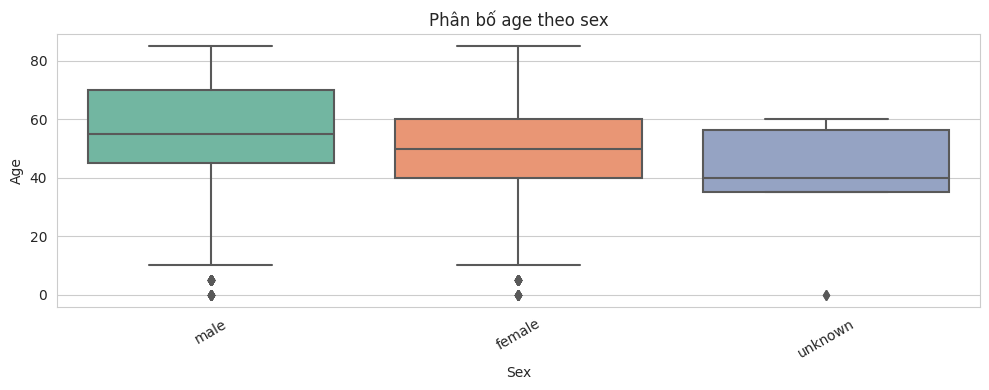

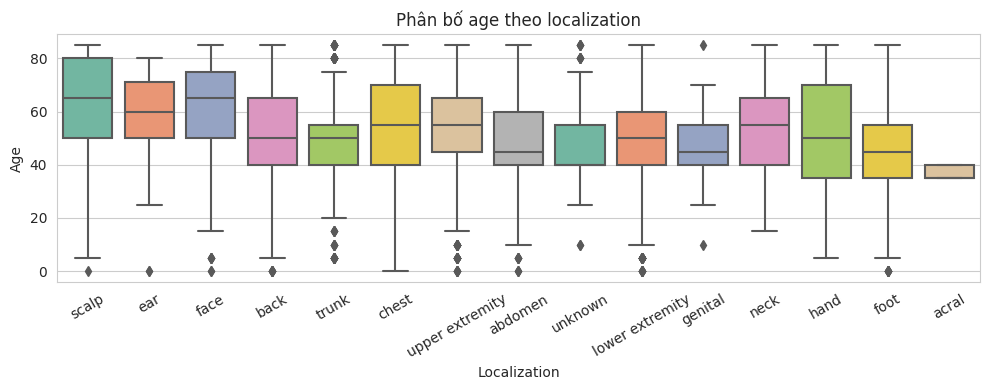

In [100]:
def plot_numerical_by_categorical_boxplot(metadata, numerical_col, categorical_cols, palette='Set2'):
    sns.set_style("whitegrid")

    for cat_col in categorical_cols:
        plt.figure(figsize=(10, 4))
        sns.boxplot(
            data=metadata,
            x=cat_col,
            y=numerical_col,
            palette=palette
        )
        plt.title(f'Phân bố {numerical_col} theo {cat_col}', fontsize=12)
        plt.xlabel(cat_col.capitalize())
        plt.ylabel(numerical_col.capitalize())
        plt.xticks(rotation=30)  # xoay nhãn cho gọn
        plt.tight_layout()
        plt.show()

for col in numerical_cols:
    plot_numerical_by_categorical_boxplot(metadata, numerical_col=col, categorical_cols=categorical_cols2)

### Nhận xét:
#### 1. Theo dx_type (loại phương pháp chẩn đoán)
- histo (giải phẫu bệnh): Phân bố rộng từ 0–85 tuổi, trung vị khoảng 55 tuổi. Giải phẫu bệnh là “tiêu chuẩn vàng” nên thường áp dụng cho mọi nhóm tuổi, không bị giới hạn bởi tuổi tác.
- consensus (đồng thuận giữa các chuyên gia): Phân bố rộng, nhưng trung vị thấp hơn (~50 tuổi).
- confocal (kính hiển vi đồng tiêu): Tập trung ở người trung niên và cao tuổi, hầu như không có bệnh nhân trẻ (<35 tuổi), trung vị ~65 tuổi. Kỹ thuật này đắt tiền, thường dùng cho bệnh nhân lớn tuổi có tổn thương phức tạp, cần tránh can thiệp xâm lấn. Ngoài ra, bệnh nhân lớn tuổi có nguy cơ ung thư da cao hơn, phù hợp với mục tiêu của phương pháp này.
- follow_up (theo dõi sau điều trị): Tuổi thấp hơn, trung vị ~50 tuổi, có một vài trường hợp rất trẻ (<10 tuổi). Nhóm này có thể bao gồm bệnh nhân đã được chẩn đoán trước đó và đang theo dõi tiến triển. 
#### 2. Theo sex (giới tính)
- Nam (male): Trung vị ~55 tuổi, phân bố rộng, có cả nhóm tuổi rất trẻ (<5 tuổi).
- Nữ (female): Trung vị ~50 tuổi, độ phân tán hẹp hơn nam, ít ca >80 tuổi.
- Không rõ (unknown): Chủ yếu tập trung ở 35–60 tuổi, ít biến động.
#### 3. Theo localization (vị trí)
- Scalp, ear, face, trunk: Median ~60–65, lệch về nhóm tuổi cao → thường do tổn thương tích lũy ánh nắng.
- Back, abdomen, chest, upper/lower extremity: Median ~50–55, xuất hiện chủ yếu ở nhóm trung niên.
- Genital, acral: Median ~40–45, phân bố hẹp, số lượng mẫu ít và dữ liệu không đa dạng.
- Nhìn chung, các vị trí phơi nắng nhiều thường gắn với bệnh nhân lớn tuổi, trong khi các vị trí đặc thù có xu hướng xuất hiện ở nhóm trẻ hơn nhưng dữ liệu hạn chế.

## 2.7 Mối quan hệ giữa cột số và nhãn

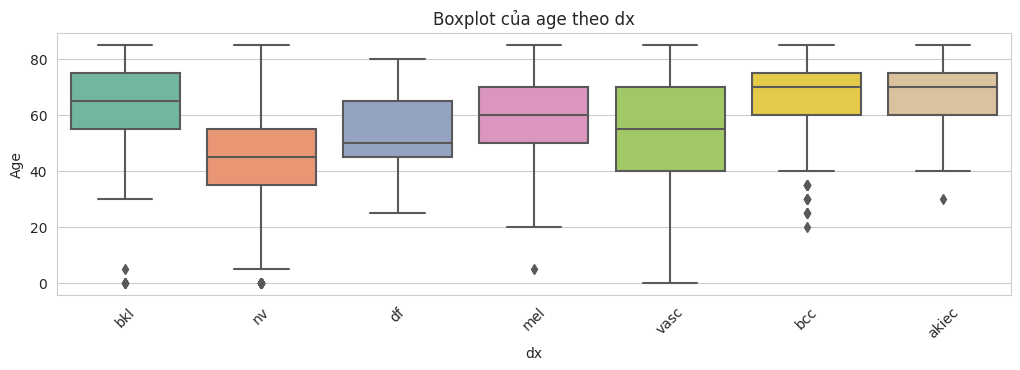

In [101]:
sns.set_style("whitegrid")

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10)) 
axes = axes.flatten()

for idx, num_col in enumerate(numerical_cols):
    ax = axes[idx]
    sns.boxplot(data=metadata, x='dx', y=num_col, palette='Set2', ax=ax)
    ax.set_title(f'Boxplot của {num_col} theo dx')
    ax.set_xlabel('dx')
    ax.set_ylabel(num_col.capitalize())
    ax.tick_params(axis='x', rotation=45)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Nhận xét:
#### Phân tích 
    - bkl (Keratosis lành tính): Trung vị tuổi ~65–70, hầu hết bệnh nhân trên 50 tuổi, rất ít ca dưới 30 tuổi. Đây là bệnh da lành tính thường gặp ở người lớn tuổi do lão hóa da. Không bất ngờ khi nhóm này tập trung ở tuổi cao.
    - nv (Nevus – nốt ruồi): Trung vị khoảng 45–50 tuổi, phân bố rộng, có nhiều ca trẻ (<20 tuổi). Nốt ruồi thường xuất hiện từ nhỏ, nhưng nguy cơ biến đổi ác tính tăng theo tuổi. Việc có nhiều ca trẻ là bình thường.
    - df (Dermatofibroma): Trung vị ~50 tuổi, phân bố tương đối hẹp. Là u xơ da lành tính, có thể gặp ở nhiều độ tuổi, nhưng thường ở người trung niên.
    - mel (Melanoma – ung thư hắc tố): Trung vị ~60 tuổi, một số ca dưới 30 tuổi. Bệnh ác tính nguy hiểm, xuất hiện nhiều ở người lớn tuổi do tích lũy tổn thương DNA từ tia UV. Các ca trẻ tuổi là hiếm nhưng đáng chú ý, cần tầm soát kỹ.
    - vasc (Lesion mạch máu): Trung vị ~50 tuổi, phân bố rộng từ sơ sinh đến >80 tuổi. Một số bệnh mạch máu là bẩm sinh (nên có ca 0 tuổi), nhưng cũng có thể xuất hiện muộn.
    - bcc (Basal Cell Carcinoma – ung thư biểu mô tế bào đáy): Trung vị ~70 tuổi, đa số trên 60 tuổi. Đây là loại ung thư da phổ biến nhất, thường gặp ở người già do phơi nhiễm ánh sáng kéo dài.
    - akiec (Actinic Keratosis / Intraepithelial Carcinoma): Trung vị ~70 tuổi, gần giống bcc. Đây là tổn thương tiền ung thư, thường ở vùng da tiếp xúc nắng nhiều, đặc biệt ở người cao tuổi.
      
#### Xu hướng chung:
    - Các bệnh lành tính như nv, df, vasc phân bố ở nhiều độ tuổi, kể cả trẻ.
    - Các bệnh ác tính hoặc tiền ung thư như bcc, akiec, mel tập trung chủ yếu ở tuổi cao (trên 60).
    - Một số loại lành tính nhưng đặc trưng tuổi cao như bkl.

## 2.8 Mối quan hệ giữa cột phân loại và nhãn


Bảng số lượng cho cột: dx_type


dx         akiec  bcc  bkl  df   mel    nv  vasc
dx_type                                         
confocal       0    0   69   0     0     0     0
consensus      0    0  264  60     0   503    75
follow_up      0    0    0   0     0  3704     0
histo        327  514  766  55  1113  2498    67

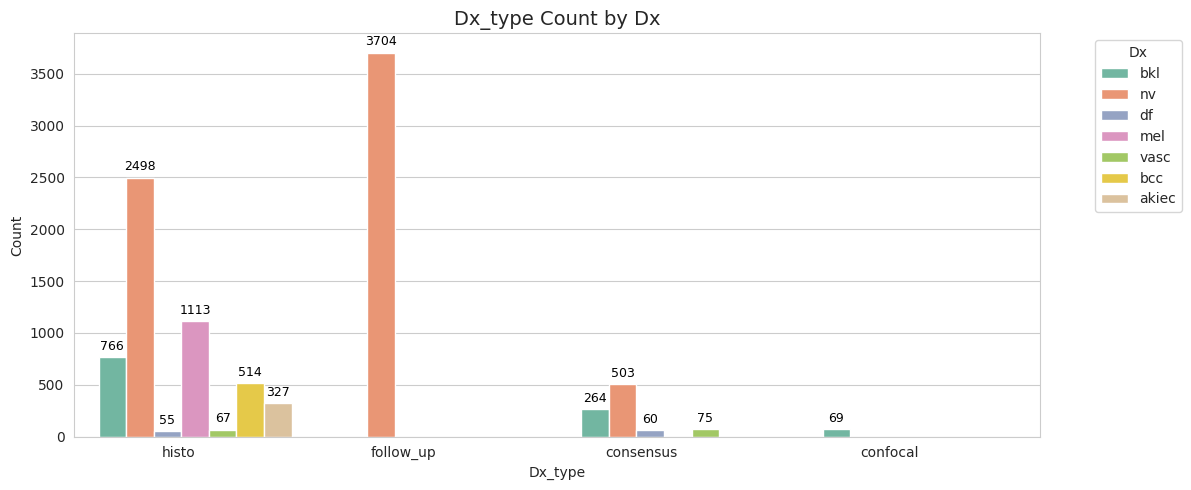


Bảng số lượng cho cột: sex


dx       akiec  bcc  bkl  df  mel    nv  vasc
sex                                          
female     106  197  463  52  424  3237    73
male       221  317  626  63  689  3421    69
unknown      0    0   10   0    0    47     0

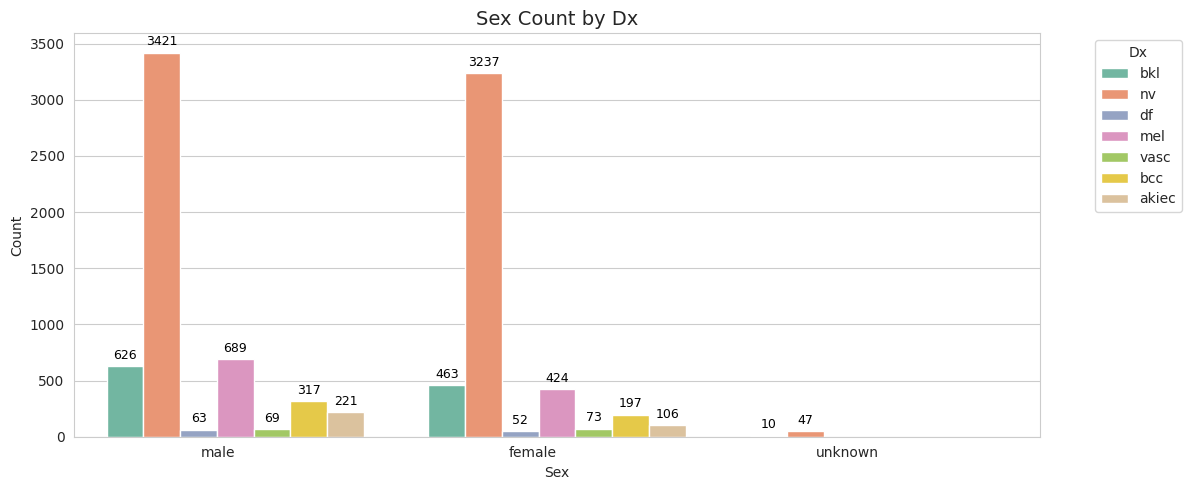

In [102]:
def plot_categorical_counts_v2(metadata, categorical_cols, target_col='dx', palette='Set2', percent=False):
    sns.set_style("whitegrid")

    unique_targets = metadata[target_col].unique()
    palette_colors = sns.color_palette(palette, len(unique_targets))
    color_dict = dict(zip(unique_targets, palette_colors))

    for col in categorical_cols:
        counts = pd.crosstab(metadata[col], metadata[target_col])
        
        order = counts.sum(axis=1).sort_values(ascending=False).index
        
        print(f"\nBảng số lượng cho cột: {col}")
        display(counts)

        plt.figure(figsize=(12, 5))
        ax = sns.countplot(
            x=col, hue=target_col, data=metadata,
            palette=color_dict, order=order
        )

        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                if percent:
                    total = metadata[metadata[col] == p.get_x()].shape[0]
                    label = f"{(height/total*100):.1f}%"
                else:
                    label = f"{height:.0f}"
                ax.annotate(label,
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            fontsize=9, color='black',
                            xytext=(0, 3), textcoords='offset points')

        ax.set_title(f'{col.capitalize()} Count by {target_col.capitalize()}', fontsize=14)
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Percentage' if percent else 'Count')
        ax.legend(title=target_col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')

        ax.set_xticklabels(ax.get_xticklabels(), ha="right")

        plt.tight_layout()
        plt.show()

# Ví dụ gọi hàm
plot_categorical_counts_v2(metadata, categorical_cols1, percent=False)


### Nhận xét
#### 1. Dx_type Count by Dx

- Phân tích chung:
    - Chẩn đoán nv hầu như chiếm áp đảo ở mọi loại Dx_type, đặc biệt là trong nhóm follow_up (3704 ca) và histo (2498 ca).
    - Một số chẩn đoán như df, vasc, bcc, akiec xuất hiện với số lượng khá ít và phân bố không đều.
    - Consensus và confocal là hai loại Dx_type có số lượng mẫu ít hơn đáng kể so với histo và follow_up.
      
- Điểm đáng chú ý:
    - mel (u ác tính) có số lượng đáng kể ở nhóm histo (1113 ca) nhưng gần như không xuất hiện ở các loại Dx_type khác.
    - confocal chỉ xuất hiện với bkl (69 ca), không có mặt ở các loại khác → dữ liệu khá mất cân đối.
      
- Ý nghĩa:
    - Dữ liệu bị mất cân bằng mạnh giữa các nhóm Dx_type và loại bệnh.
    - Có thể ảnh hưởng đến mô hình học máy, cần cân nhắc phương pháp xử lý mất cân bằng.
      
#### 2. Sex Count by Dx

- Phân tích chung:
    - nv tiếp tục là loại bệnh áp đảo ở cả nam (3421 ca) và nữ (3237 ca).
    - mel có xu hướng xuất hiện nhiều hơn ở nam (689 ca) so với nữ (424 ca).
    - Một số loại bệnh như vasc, bcc, akiec có số lượng nhỏ và không cân đối giữa hai giới.
    - Nhóm unknown giới tính rất ít dữ liệu (57 ca), chủ yếu là nv.

- Điểm đáng chú ý:
    - Sự phân bố bệnh theo giới tính có vẻ không đồng đều: một số bệnh như mel và bcc xuất hiện nhiều ở nam hơn nữ.
    - Nếu phân tích yếu tố giới tính, cần xem xét sự mất cân bằng này để tránh bias.

- Ý nghĩa:
    - Mất cân bằng dữ liệu không chỉ theo loại bệnh mà còn theo giới tính.
    - Có thể cần cân nhắc phân tích phân tách theo giới để phát hiện xu hướng dịch tễ.

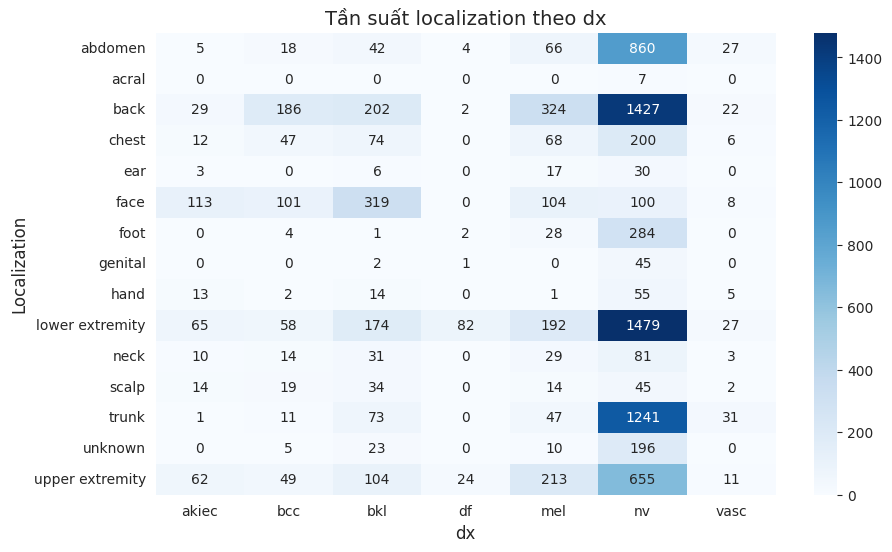

In [ ]:
ct = pd.crosstab(metadata['localization'], metadata['dx'])
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Tần suất localization theo dx", fontsize=14)
plt.xlabel("dx", fontsize=12)
plt.ylabel("Localization", fontsize=12)
plt.show()

#### 3. Localization Count by Dx
- Số lượng cao: Back & lower extremity nhiều ca nv (1,427 & 1,479), trunk cũng cao (1,241).
- Bệnh nổi bật theo vị trí: bcc nhiều ở back (186) & face (101), bkl ở back (202) & face (319), mel phân bố rộng, nhiều nhất back (324) & lower extremity (192).
- Ít xuất hiện: Acral, ear, genital, unknown rất hiếm.
- Tổng quan: nv chiếm ưu thế ở nhiều vị trí; các bệnh khác tập trung vùng tiếp xúc ánh sáng.

# 3. EDA cho Ảnh

In [ ]:
image_dirs = ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']

metadata['file_name'] = metadata['image_id'] + '.jpg'
metadata['path'] = metadata['file_name'].apply(
    lambda x: next((os.path.join(d, x) for d in image_dirs if os.path.exists(os.path.join(d, x))), None)
)

## 3.1 Kiểm tra kích thước ảnh

In [105]:
sizes = []
for p in metadata['path']:
    with Image.open(p) as img:
        w, h = img.size
        sizes.append((w, h, w/h))

sizes_df = pd.DataFrame(sizes, columns=['width','height','ratio'])
display(sizes_df.describe())

width   height         ratio
count  10015.0  10015.0  1.001500e+04
mean     600.0    450.0  1.333333e+00
std        0.0      0.0  1.598801e-13
min      600.0    450.0  1.333333e+00
25%      600.0    450.0  1.333333e+00
50%      600.0    450.0  1.333333e+00
75%      600.0    450.0  1.333333e+00
max      600.0    450.0  1.333333e+00

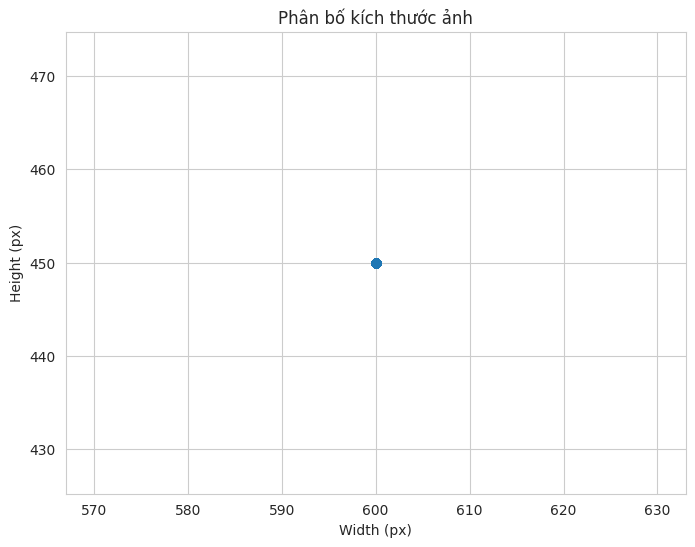

In [106]:
plt.figure(figsize=(8, 6))
plt.scatter(sizes_df['width'], sizes_df['height'], alpha=0.5)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Phân bố kích thước ảnh")
plt.grid(True)
plt.show()

### Nhận xét:
Tất cả các ảnh đều có kích thước 600x450

## 3.2 Kiểm tra chất lượng ảnh (blur, quá tối/sáng)

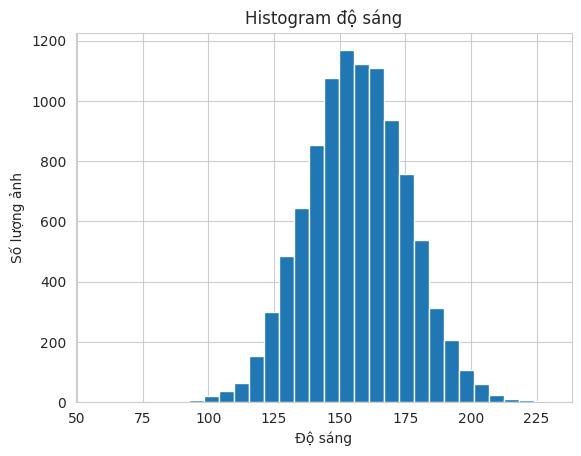

In [107]:
from PIL import ImageStat

brightness = []
for p in metadata['path']:
    with Image.open(p) as img:
        stat = ImageStat.Stat(img.convert('L'))  # Grayscale
        brightness.append(stat.mean[0])

plt.hist(brightness, bins=30)
plt.title('Histogram độ sáng')
plt.xlabel('Độ sáng')
plt.ylabel('Số lượng ảnh')
plt.show()

### Nhận xét
#### 1. Hình dạng phân bố
- Dữ liệu có dạng phân bố chuẩn (normal distribution), gần như đối xứng quanh giá trị trung tâm.

- Đỉnh phân bố rơi vào khoảng 150–155 trên thang đo độ sáng.

- Phần lớn ảnh có độ sáng nằm trong khoảng 130–170, chiếm đa số dữ liệu.

#### 2. Ý nghĩa về dữ liệu
- Độ sáng ảnh tương đối đồng đều, không có nhiều ảnh quá tối (<100) hoặc quá sáng (>200).

- Tập ảnh có chất lượng ánh sáng khá ổn định, ít biến động mạnh

In [108]:
def expo_stats(p):
    with Image.open(p) as im:
        g = np.asarray(im.convert('L'))
    tot = g.size
    under = (g <= 5).sum() / tot
    over  = (g >= 250).sum() / tot
    return under, over

tmp_data = metadata.copy()
expo = tmp_data['path'].apply(expo_stats)
tmp_data['pct_under'], tmp_data['pct_over'] = zip(*expo)
display(tmp_data[['pct_under','pct_over']].describe())

pct_under      pct_over
count  10015.000000  10015.000000
mean       0.000899      0.000135
std        0.005690      0.003555
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.000000
max        0.127119      0.257400

#### Nhận xét:
- Bộ dữ liệu nhìn chung rất ít ảnh bị tối hoặc cháy sáng, cho thấy điều kiện chụp/thu thập dữ liệu khá tốt.

- Tuy nhiên, vẫn tồn tại một số ảnh outlier có tỷ lệ pixel quá tối (>10%) hoặc quá sáng (>20%) → có thể gây nhiễu khi huấn luyện mô hình.

- Các ảnh median = 0 và Q3 = 0 cho thấy phân bố lệch nhiều về phía 0, tức là hầu hết dữ liệu nằm trong vùng an toàn.

## 3.3 Hiển thị ảnh mẫu mỗi lớp

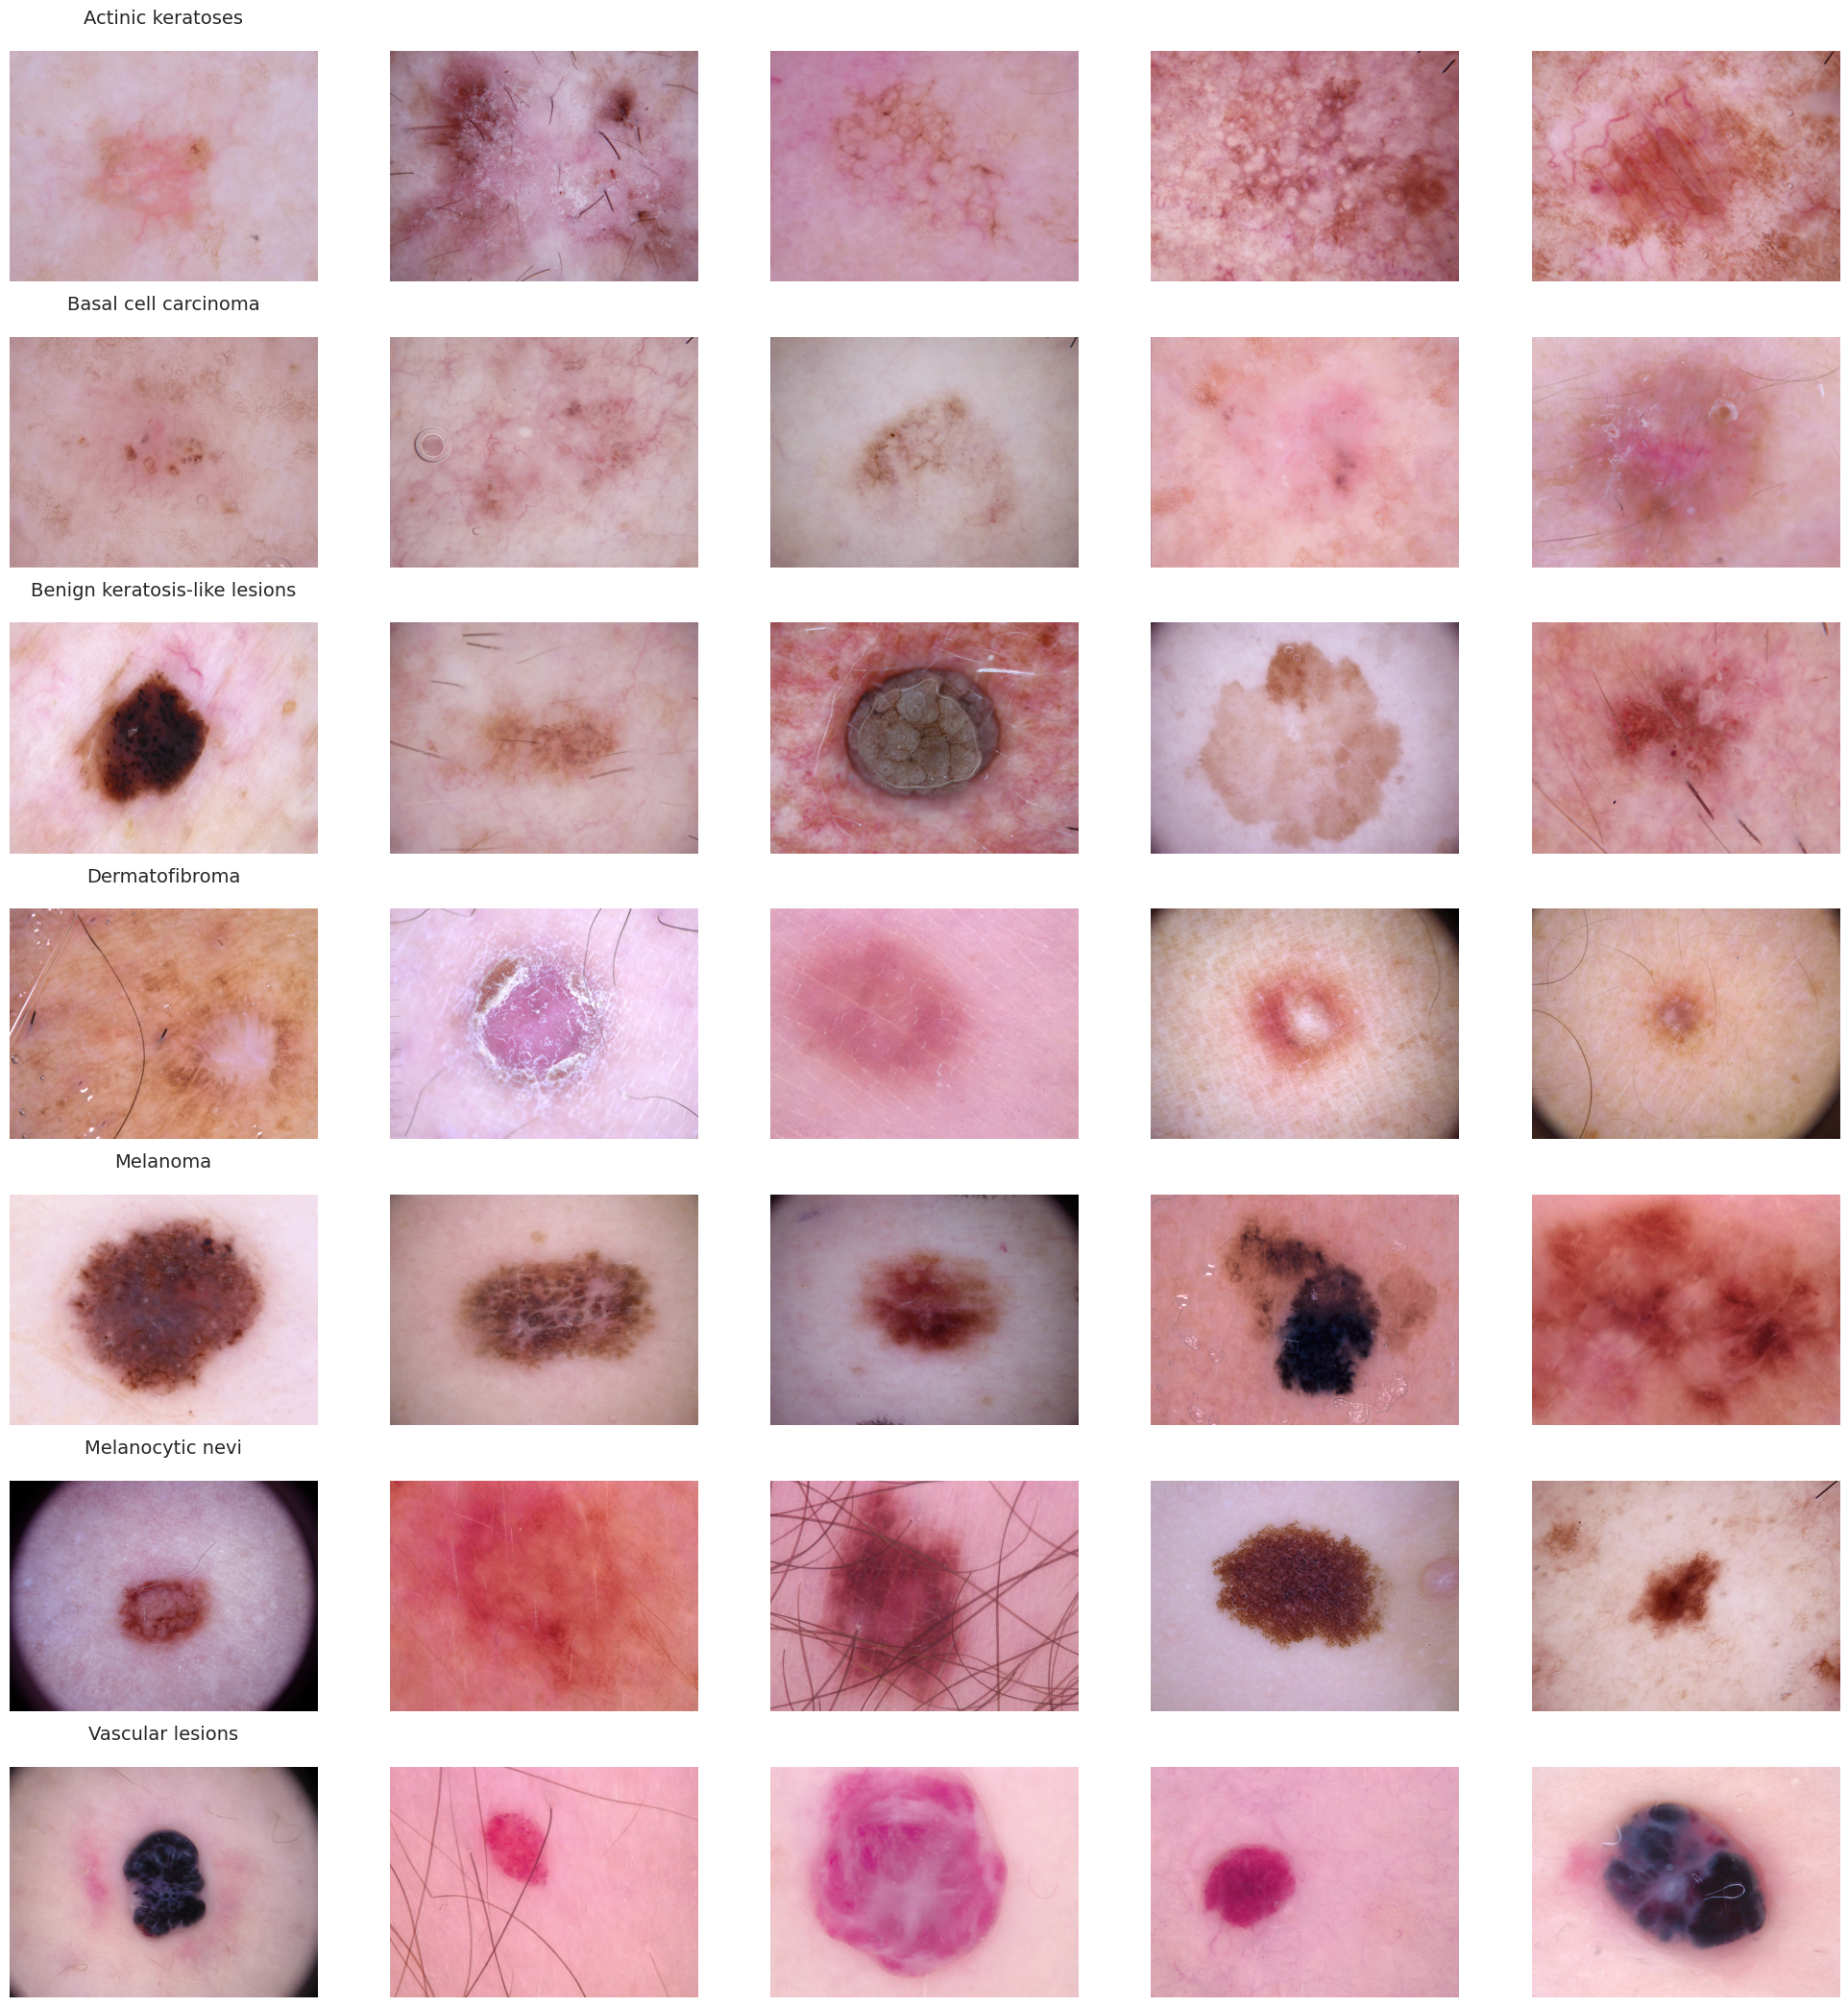

In [109]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

n_samples = 5
categories = metadata['dx'].unique()
n_categories = len(categories)

fig, m_axs = plt.subplots(n_categories, n_samples, figsize=(4*n_samples, 3*n_categories))

if n_categories == 1:
    m_axs = [m_axs]

for row_axs, (type_name, type_rows) in zip(m_axs, metadata.sort_values('dx').groupby('dx')):
    full_name = lesion_type_dict.get(type_name, type_name)

    row_axs[0].set_title(full_name, fontsize=14, pad=20)
    for ax, (_, c_row) in zip(row_axs, type_rows.sample(min(n_samples, len(type_rows)), random_state=1234).iterrows()):
        img = mpimg.imread(c_row['path'])
        ax.imshow(img)
        ax.axis('off')

plt.tight_layout()
plt.savefig('category_samples.png', dpi=300)
plt.show()

## 3.4 Histogram pixel (phân phối giá trị màu)

Đang xử lý ảnh: 100%|██████████| 10015/10015 [03:09<00:00, 52.84it/s]


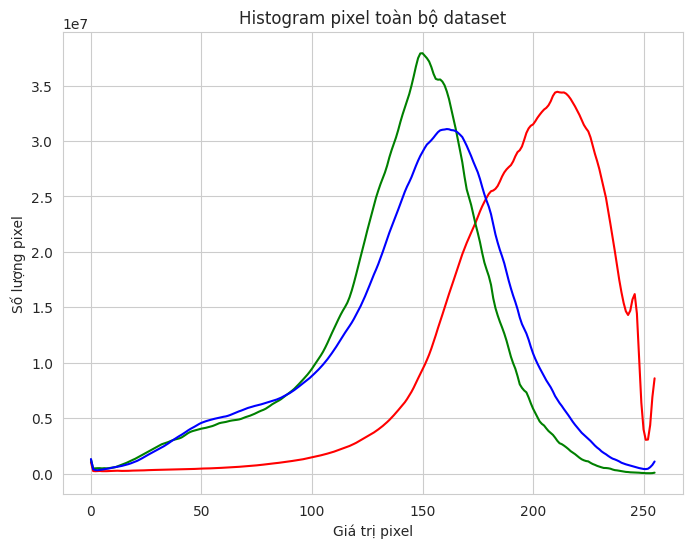

In [ ]:
# Khởi tạo histogram rỗng cho R, G, B
hist_r = np.zeros(256)
hist_g = np.zeros(256)
hist_b = np.zeros(256)

# Duyệt tất cả ảnh
for p in tqdm(metadata['path'], desc="Đang xử lý ảnh"):
    with Image.open(p) as img:
        img = img.convert('RGB')  
        r, g, b = img.split()
        
        hist_r += np.histogram(np.array(r).flatten(), bins=256, range=(0, 256))[0]
        hist_g += np.histogram(np.array(g).flatten(), bins=256, range=(0, 256))[0]
        hist_b += np.histogram(np.array(b).flatten(), bins=256, range=(0, 256))[0]

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.plot(hist_r, color='red')
plt.plot(hist_g, color='green')
plt.plot(hist_b, color='blue')
plt.title("Histogram pixel toàn bộ dataset")
plt.xlabel("Giá trị pixel")
plt.ylabel("Số lượng pixel")
plt.show()

### Nhận xét:
* Kênh đỏ (R) có đỉnh rõ rệt ở vùng giá trị ~200–230 → nghĩa là ảnh có xu hướng thiên đỏ / nóng hơn.

* Kênh xanh lá (G) và xanh dương (B) tập trung ở vùng ~140–160 → sáng trung bình, ít điểm bão hòa ở giá trị cao nhất.

* Không thấy nhiều pixel ở vùng tối (< 50) → dataset ít ảnh tối hoặc chụp ban đêm.

* Phần lớn pixel nằm từ 100–230, nghĩa là ảnh sáng, độ tương phản vừa phải.

* Cả ba kênh đều có dạng lệch phải (right-skewed), không phải Gaussian.

* Kênh R vượt trội so với G và B

## 3.5 Kiểm tra kênh ảnh (RGB/Gray/RGBA)

In [112]:
modes = metadata['path'].apply(
    lambda p: Image.open(p).mode
)
display(modes.value_counts()) 

path
RGB    10015
Name: count, dtype: int64

## 3.6 Kiểm tra ảnh bị lỗi

In [113]:
bad_images = []
for p in metadata['path']:
    try:
        with Image.open(p) as img:
            img.verify()  
    except:
        bad_images.append(p)

print(f"Tổng ảnh lỗi: {len(bad_images)}")
if bad_images:
    print(bad_images)

Tổng ảnh lỗi: 0


## 3.7 Kiểm tra ảnh trùng/near-duplicate

In [ ]:
hash_to_paths = defaultdict(list)
for p in metadata['path']:
    with Image.open(p) as im:
        h = imagehash.phash(im.convert('RGB'))
    hash_to_paths[str(h)].append(p)

dups = {h:ps for h,ps in hash_to_paths.items() if len(ps) > 1}
print("Cụm ảnh trùng/na ná nhau:", len(dups))

# Kiểm tra trùng nhưng khác nhãn
path_to_dx = dict(zip(metadata['path'], metadata['dx']))
suspicious = {h:[(pp, path_to_dx[pp]) for pp in ps] for h,ps in dups.items()}

Cụm ảnh trùng/na ná nhau: 19


## 3.8 Tính class weights

In [ ]:
classes = np.unique(metadata['dx'])
weights = compute_class_weight('balanced', classes=classes, y=metadata['dx'])
class_weights = dict(zip(classes, weights))
print("Class weights: ", class_weights)

Class weights:  {'akiec': 4.375273044997815, 'bcc': 2.78349082823791, 'bkl': 1.301832835044846, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'nv': 0.21338020666879728, 'vasc': 10.075452716297788}


## 3.9 Mean và std từng kênh

In [116]:
sum_rgb = np.zeros(3, dtype=np.float64)
sum2_rgb = np.zeros(3, dtype=np.float64)
n_pix_total = 0

for p in metadata['path']:
    with Image.open(p) as im:
        arr = np.asarray(im.convert('RGB'), dtype=np.float32) / 255.0
    h, w, _ = arr.shape
    n = h*w
    sum_rgb  += arr.reshape(-1,3).sum(0)
    sum2_rgb += (arr.reshape(-1,3)**2).sum(0)
    n_pix_total += n

mean = sum_rgb / n_pix_total
std  = np.sqrt(sum2_rgb / n_pix_total - mean**2)
print("Mean RGB:", mean, "Std RGB:", std)

Mean RGB: [0.76295826 0.54608316 0.57044073] Std RGB: [0.14454205 0.15345059 0.17092999]


# II. Data Preprocessing

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from tqdm import tqdm
from torchvision.models import resnet50
from torchvision.models import efficientnet_b0
from torchvision.models import resnet18
from efficientnet_pytorch import EfficientNet
from torchvision.models import vgg16
from torchvision.models import densenet121
from torchvision.models import mobilenet_v2


## 1. Image

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## 2. Metadata

In [ ]:
# Age scaling
scaler = MinMaxScaler()
metadata['age_scaled'] = scaler.fit_transform(metadata[['age']].fillna(metadata['age'].median()))

# Encoding
sex_ohe = pd.get_dummies(metadata['sex'].fillna('unknown'), prefix='sex')
loc_ohe = pd.get_dummies(metadata['localization'].fillna('unknown'), prefix='localization')
le_dxt = LabelEncoder()
metadata['dx_type_encoded'] = le_dxt.fit_transform(metadata['dx_type'])
le_dx = LabelEncoder()
metadata['dx_encoded'] = le_dx.fit_transform(metadata['dx'])

# Combine tabular features
tabular_features = pd.concat([
    metadata[['age_scaled']],
    sex_ohe,
    loc_ohe,
    metadata[['dx_type_encoded']]
], axis=1)

# Define tabular column names (fixed for all datasets)
tabular_cols = tabular_features.columns.tolist()

# Merge back to metadata
metadata = pd.concat([metadata, tabular_features], axis=1)

# III. Models

In [ ]:
class SkinDataset1(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(df['dx'].unique())
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        label = self.df.loc[idx, 'dx']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[label]
    

class SkinDataset2(Dataset):
    def __init__(self, df, transform=None, tabular_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.tabular_cols = tabular_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'path']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Tabular data
        tabular_data = torch.tensor(
            self.df.loc[idx, self.tabular_cols].values.astype(np.float32)
        ).flatten()  # Ensure 1D

        label = torch.tensor(self.df.loc[idx, 'dx_encoded'], dtype=torch.long)
        return image, tabular_data, label

In [5]:
def train_model1(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    train_acc_history, val_acc_history = [], []
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), "best_model.pt")

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history


def train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, tabs, labels in tqdm(train_loader):
            images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, tabs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    return history



def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, tabs, labels in loader:
            images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
            outputs = model(images, tabs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

In [ ]:
def plot_training_curves(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()



def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(8,6), cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
train_df, temp_df = train_test_split(metadata, test_size=0.3, stratify=metadata['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. ResNet50

### 1.1 Model ảnh

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s] 


Epoch 1/10
----------
train Loss: 0.8759 Acc: 0.6874
val Loss: 0.9540 Acc: 0.6884
Epoch 2/10
----------
train Loss: 0.7759 Acc: 0.7126
val Loss: 0.8916 Acc: 0.6411
Epoch 3/10
----------
train Loss: 0.7600 Acc: 0.7147
val Loss: 1.0092 Acc: 0.6904
Epoch 4/10
----------
train Loss: 0.7849 Acc: 0.7144
val Loss: 0.7128 Acc: 0.7290
Epoch 5/10
----------
train Loss: 0.7145 Acc: 0.7331
train Loss: 0.6941 Acc: 0.7411
val Loss: 0.6782 Acc: 0.7483
Epoch 7/10
----------
train Loss: 0.6558 Acc: 0.7579
val Loss: 0.6691 Acc: 0.7483
Epoch 8/10
----------
train Loss: 0.5834 Acc: 0.7825
val Loss: 0.6020 Acc: 0.7710
Epoch 9/10
----------
train Loss: 0.5589 Acc: 0.7920
val Loss: 0.5950 Acc: 0.7790
Epoch 10/10
----------
train Loss: 0.5457 Acc: 0.8009
val Loss: 0.6031 Acc: 0.7763


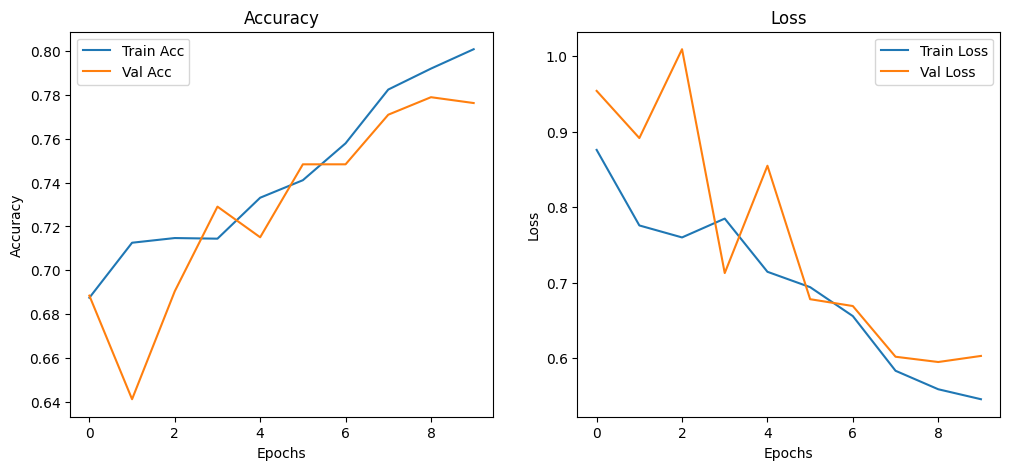


Classification Report:
              precision    recall  f1-score   support

       akiec       0.51      0.47      0.49        49
         bcc       0.63      0.58      0.61        77
         bkl       0.54      0.49      0.51       165
          df       0.00      0.00      0.00        17
         mel       0.56      0.43      0.48       167
          nv       0.86      0.94      0.90      1006
        vasc       0.89      0.73      0.80        22

    accuracy                           0.79      1503
   macro avg       0.57      0.52      0.54      1503
weighted avg       0.76      0.79      0.77      1503



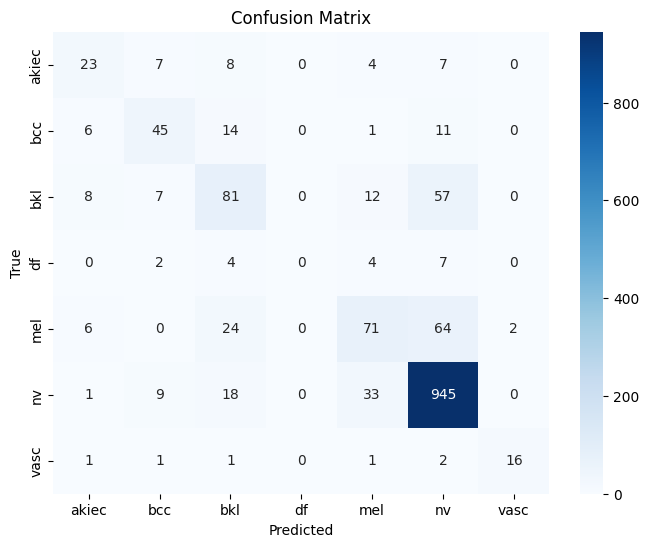

In [ ]:
train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


model = resnet50(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=10)


plot_training_curves(train_acc, val_acc, train_loss, val_loss)


model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)

### 1.2 Model kết hợp cả bảng và ảnh

100%|██████████| 220/220 [01:48<00:00,  2.02it/s]


Epoch [1/10] Train Loss: 0.7018 Train Acc: 0.7478 Val Loss: 0.5335 Val Acc: 0.7969


100%|██████████| 220/220 [01:48<00:00,  2.02it/s]


Epoch [2/10] Train Loss: 0.4701 Train Acc: 0.8335 Val Loss: 0.4947 Val Acc: 0.8249


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [3/10] Train Loss: 0.3718 Train Acc: 0.8668 Val Loss: 0.4882 Val Acc: 0.8389


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [4/10] Train Loss: 0.2930 Train Acc: 0.8986 Val Loss: 0.5968 Val Acc: 0.7916


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [5/10] Train Loss: 0.2551 Train Acc: 0.9113 Val Loss: 0.4161 Val Acc: 0.8728


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [6/10] Train Loss: 0.2160 Train Acc: 0.9274 Val Loss: 0.4224 Val Acc: 0.8602


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [7/10] Train Loss: 0.1404 Train Acc: 0.9508 Val Loss: 0.4160 Val Acc: 0.8635


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [8/10] Train Loss: 0.1152 Train Acc: 0.9606 Val Loss: 0.4561 Val Acc: 0.8575


100%|██████████| 220/220 [01:48<00:00,  2.03it/s]


Epoch [9/10] Train Loss: 0.0898 Train Acc: 0.9698 Val Loss: 0.4861 Val Acc: 0.8688


100%|██████████| 220/220 [01:51<00:00,  1.98it/s]


Epoch [10/10] Train Loss: 0.1008 Train Acc: 0.9645 Val Loss: 0.6581 Val Acc: 0.8362


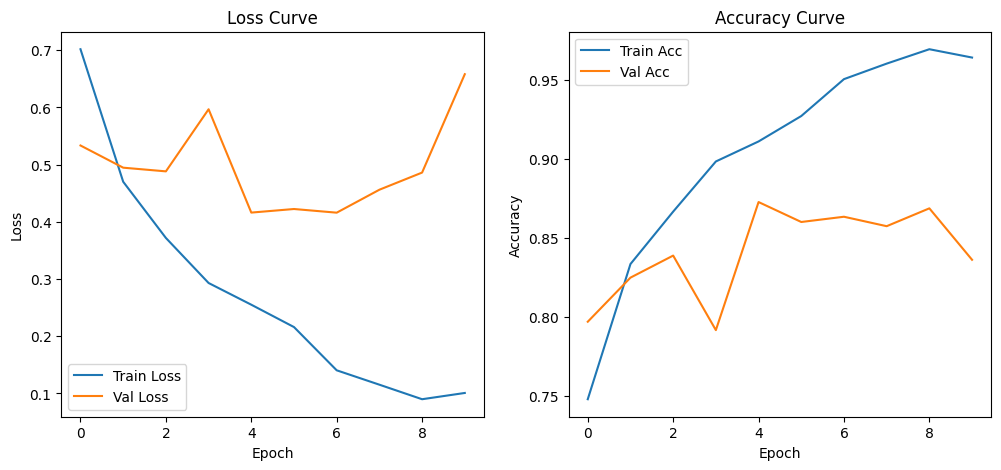


Classification Report:
              precision    recall  f1-score   support

       akiec       0.35      0.84      0.50        49
         bcc       0.67      0.86      0.75        77
         bkl       0.84      0.52      0.64       165
          df       0.82      0.53      0.64        17
         mel       0.76      0.45      0.56       167
          nv       0.92      0.97      0.94      1006
        vasc       0.93      0.59      0.72        22

    accuracy                           0.84      1503
   macro avg       0.76      0.68      0.68      1503
weighted avg       0.86      0.84      0.84      1503



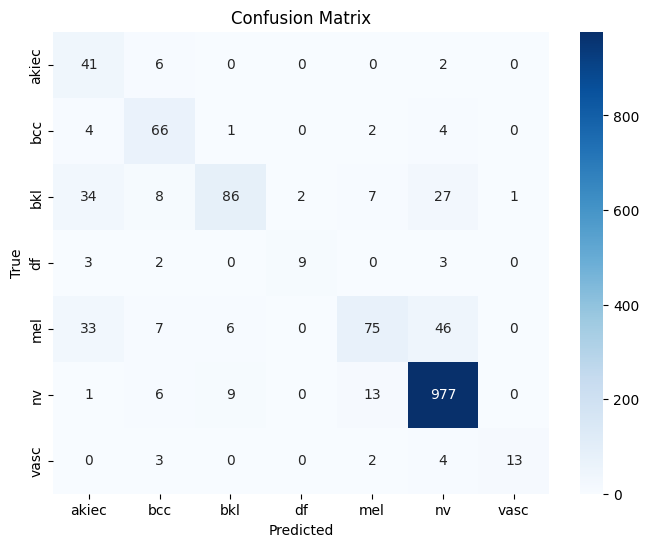

Model saved as resnet50+meta_01.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # ResNet50 backbone
        self.cnn = resnet50(weights='IMAGENET1K_V1')
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # bỏ FC cuối để lấy đặc trưng ảnh

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

sample_tab_shape = train_dataset[0][1].shape[0]
model = MultiModalNet(
    num_classes=len(le_dx.classes_),
    tabular_input_dim=sample_tab_shape
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

# ===== 13. Save model =====
torch.save(model.state_dict(), "resnet50+meta_01.pth")
print("Model saved as resnet50+meta_01.pth")

## 2. ResNet18

### 2.1 Model ảnh

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch 1/10
----------
train Loss: 0.8357 Acc: 0.7023
val Loss: 0.7728 Acc: 0.7217
Epoch 2/10
----------
train Loss: 0.6970 Acc: 0.7412
val Loss: 0.6858 Acc: 0.7656
Epoch 3/10
----------
train Loss: 0.6694 Acc: 0.7509
val Loss: 2.5217 Acc: 0.6079
Epoch 4/10
----------
train Loss: 0.6956 Acc: 0.7474
val Loss: 0.7283 Acc: 0.7370
Epoch 5/10
----------
train Loss: 0.5816 Acc: 0.7793
val Loss: 0.6835 Acc: 0.7770
Epoch 6/10
----------
train Loss: 0.5539 Acc: 0.7906
val Loss: 0.6471 Acc: 0.7643
Epoch 7/10
----------
train Loss: 0.5248 Acc: 0.8043
val Loss: 0.6013 Acc: 0.7830
Epoch 8/10
----------
train Loss: 0.4083 Acc: 0.8476
val Loss: 0.4735 Acc: 0.8329
Epoch 9/10
----------
train Loss: 0.3487 Acc: 0.8736
val Loss: 0.4884 Acc: 0.8262
Epoch 10/10
----------
train Loss: 0.3207 Acc: 0.8813
val Loss: 0.4720 Acc: 0.8242


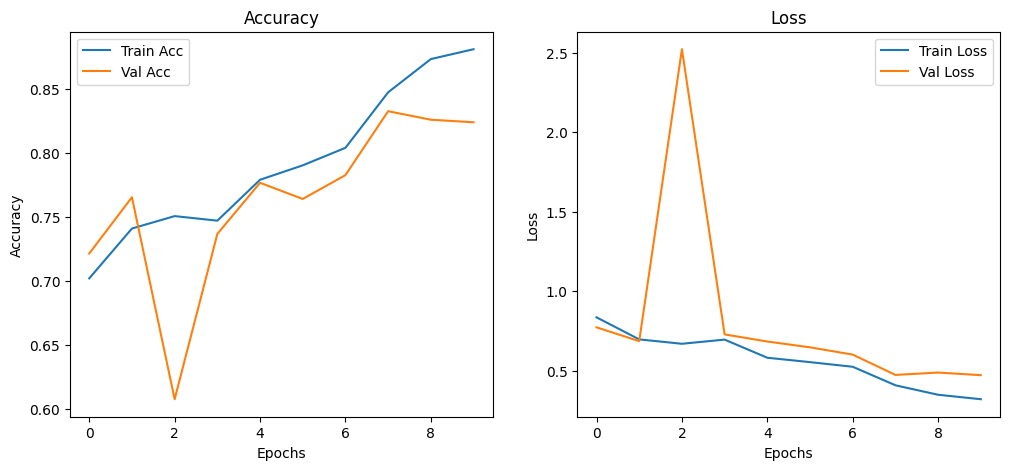


Classification Report:
              precision    recall  f1-score   support

       akiec       0.56      0.61      0.58        49
         bcc       0.65      0.86      0.74        77
         bkl       0.67      0.64      0.65       165
          df       0.86      0.35      0.50        17
         mel       0.65      0.47      0.55       167
          nv       0.90      0.93      0.92      1006
        vasc       1.00      0.73      0.84        22

    accuracy                           0.83      1503
   macro avg       0.75      0.66      0.68      1503
weighted avg       0.82      0.83      0.82      1503



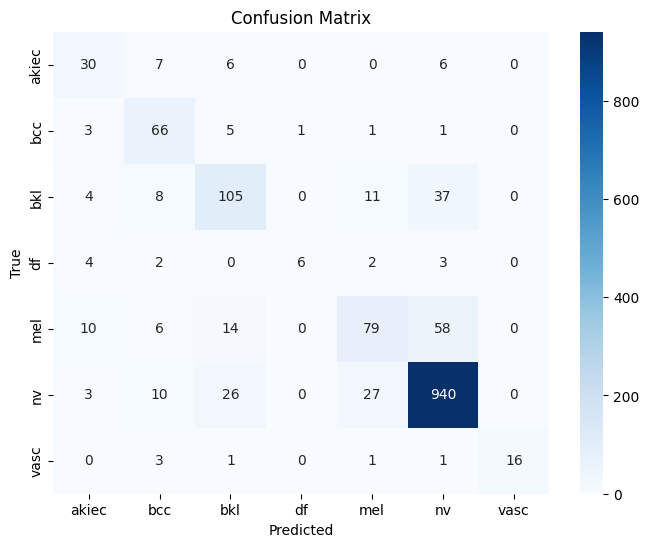

In [ ]:
train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


model = resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=10)


plot_training_curves(train_acc, val_acc, train_loss, val_loss)


model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)

### 2.2 Model kết hợp cả bảng và ảnh

100%|██████████| 220/220 [01:18<00:00,  2.79it/s]


Epoch [1/10] Train Loss: 0.6914 Train Acc: 0.7572 Val Loss: 0.5156 Val Acc: 0.8089


100%|██████████| 220/220 [01:19<00:00,  2.77it/s]


Epoch [2/10] Train Loss: 0.4392 Train Acc: 0.8384 Val Loss: 0.5754 Val Acc: 0.8063


100%|██████████| 220/220 [01:17<00:00,  2.84it/s]


Epoch [3/10] Train Loss: 0.3206 Train Acc: 0.8873 Val Loss: 0.4062 Val Acc: 0.8502


100%|██████████| 220/220 [01:16<00:00,  2.86it/s]


Epoch [4/10] Train Loss: 0.2303 Train Acc: 0.9198 Val Loss: 0.4453 Val Acc: 0.8502


100%|██████████| 220/220 [01:17<00:00,  2.84it/s]


Epoch [5/10] Train Loss: 0.1796 Train Acc: 0.9368 Val Loss: 0.5636 Val Acc: 0.8356


100%|██████████| 220/220 [01:17<00:00,  2.83it/s]


Epoch [6/10] Train Loss: 0.1319 Train Acc: 0.9541 Val Loss: 0.4330 Val Acc: 0.8622


100%|██████████| 220/220 [01:17<00:00,  2.85it/s]


Epoch [7/10] Train Loss: 0.0967 Train Acc: 0.9686 Val Loss: 0.4929 Val Acc: 0.8642


100%|██████████| 220/220 [01:17<00:00,  2.83it/s]


Epoch [8/10] Train Loss: 0.0946 Train Acc: 0.9700 Val Loss: 0.4742 Val Acc: 0.8622


100%|██████████| 220/220 [01:18<00:00,  2.81it/s]


Epoch [9/10] Train Loss: 0.0949 Train Acc: 0.9668 Val Loss: 0.4230 Val Acc: 0.8655


100%|██████████| 220/220 [01:17<00:00,  2.83it/s]


Epoch [10/10] Train Loss: 0.0591 Train Acc: 0.9807 Val Loss: 0.5634 Val Acc: 0.8602


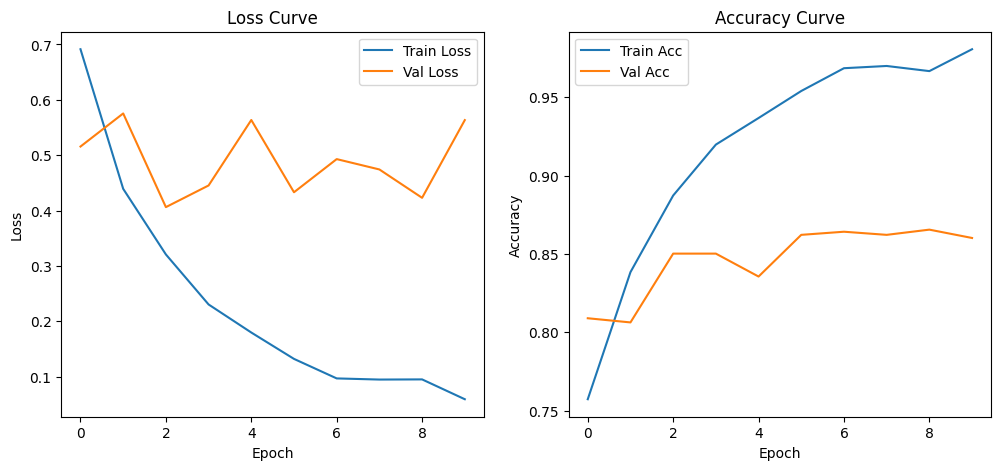


Classification Report:
              precision    recall  f1-score   support

       akiec       0.63      0.49      0.55        49
         bcc       0.78      0.77      0.77        77
         bkl       0.68      0.75      0.71       165
          df       1.00      0.47      0.64        17
         mel       0.75      0.43      0.54       167
          nv       0.88      0.96      0.92      1006
        vasc       0.93      0.64      0.76        22

    accuracy                           0.84      1503
   macro avg       0.81      0.64      0.70      1503
weighted avg       0.84      0.84      0.83      1503



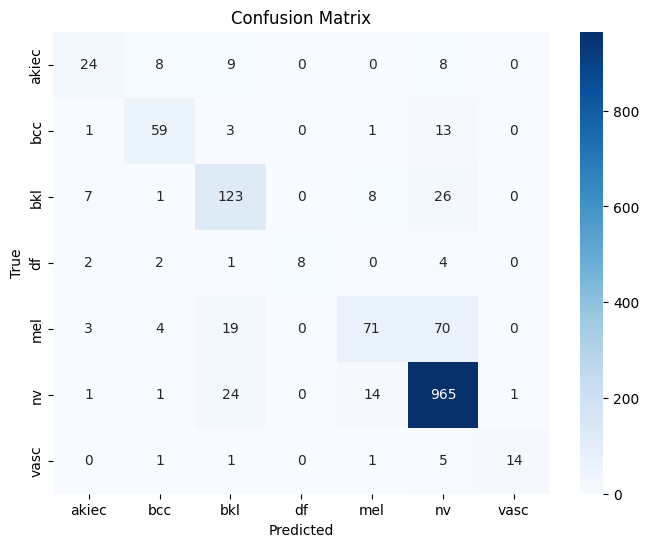

Model saved as resnet18+meta_01.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # ResNet-18 backbone
        self.cnn = resnet18(weights='IMAGENET1K_V1')
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_tab_shape = train_dataset[0][1].shape[0]
model = MultiModalNet(
    num_classes=len(le_dx.classes_),
    tabular_input_dim=sample_tab_shape
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

torch.save(model.state_dict(), "resnet18+meta_01.pth")
print("Model saved as resnet18+meta_01.pth")

## 3. EfficientNetB0

### 3.1 Model ảnh

Loaded pretrained weights for efficientnet-b0
Epoch 1/50
----------
train Loss: 0.7026 Acc: 0.7499
val Loss: 0.7690 Acc: 0.7683
Epoch 2/50
----------
train Loss: 0.4824 Acc: 0.8213
val Loss: 0.7733 Acc: 0.7716
Epoch 3/50
----------
train Loss: 0.4068 Acc: 0.8488
val Loss: 0.7020 Acc: 0.7790
Epoch 4/50
----------
train Loss: 0.3266 Acc: 0.8822
val Loss: 0.4952 Acc: 0.8442
Epoch 5/50
----------
train Loss: 0.2685 Acc: 0.9026
val Loss: 0.5141 Acc: 0.8282
Epoch 6/50
----------
train Loss: 0.2190 Acc: 0.9217
val Loss: 0.5352 Acc: 0.8375
Epoch 7/50
----------
train Loss: 0.1973 Acc: 0.9348
val Loss: 0.5614 Acc: 0.8402
Epoch 8/50
----------
train Loss: 0.0980 Acc: 0.9656
val Loss: 0.4087 Acc: 0.8782
Epoch 9/50
----------
train Loss: 0.0625 Acc: 0.9813
val Loss: 0.4322 Acc: 0.8808
Epoch 10/50
----------
train Loss: 0.0427 Acc: 0.9873
val Loss: 0.4428 Acc: 0.8775
Epoch 11/50
----------
train Loss: 0.0348 Acc: 0.9912
val Loss: 0.4550 Acc: 0.8788
Epoch 12/50
----------
train Loss: 0.0305 Acc: 0.9

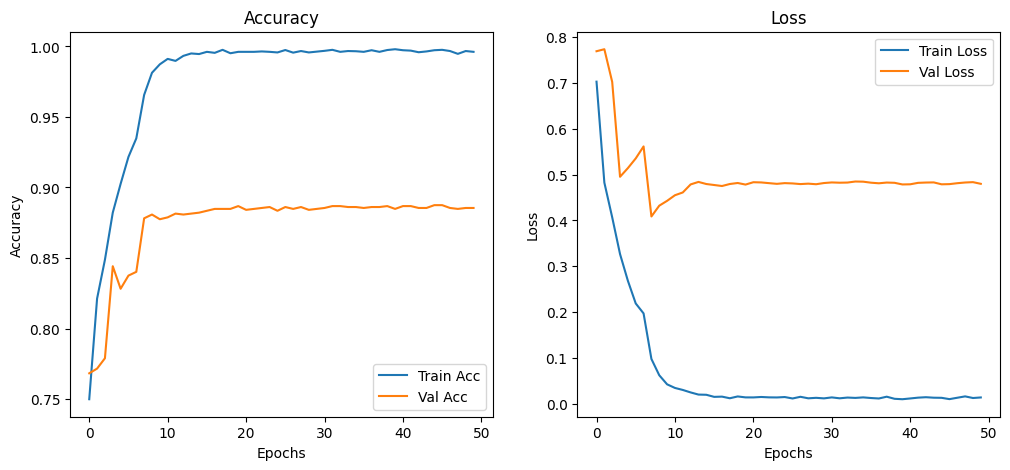


Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.71      0.73        49
         bcc       0.75      0.82      0.78        77
         bkl       0.82      0.78      0.80       165
          df       0.91      0.59      0.71        17
         mel       0.80      0.63      0.71       167
          nv       0.92      0.97      0.95      1006
        vasc       1.00      0.86      0.93        22

    accuracy                           0.89      1503
   macro avg       0.85      0.77      0.80      1503
weighted avg       0.89      0.89      0.88      1503



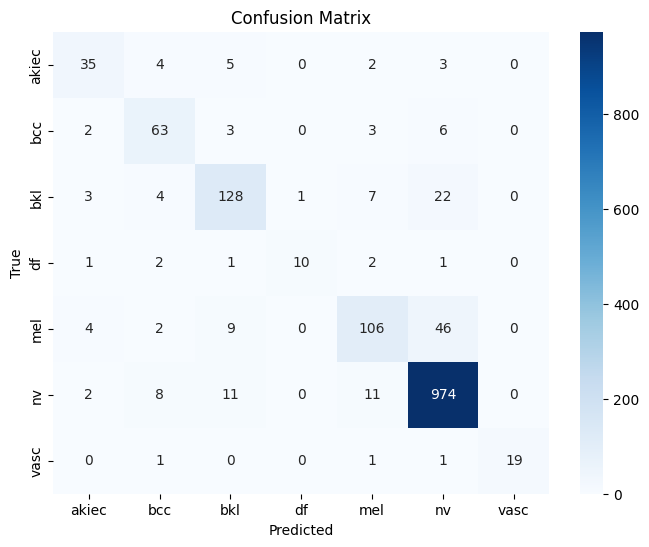

In [ ]:
train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

model = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=50)

plot_training_curves(train_acc, val_acc, train_loss, val_loss)

model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)

### 3.2 Model kết hợp cả bảng và ảnh

100%|██████████| 254/254 [01:48<00:00,  2.33it/s]


Epoch [1/10] Train Loss: 0.9700 Train Acc: 0.7238 Val Loss: 0.5436 Val Acc: 0.8093


100%|██████████| 254/254 [01:46<00:00,  2.38it/s]


Epoch [2/10] Train Loss: 0.4635 Train Acc: 0.8323 Val Loss: 0.4073 Val Acc: 0.8570


100%|██████████| 254/254 [01:46<00:00,  2.39it/s]


Epoch [3/10] Train Loss: 0.3217 Train Acc: 0.8866 Val Loss: 0.3957 Val Acc: 0.8647


100%|██████████| 254/254 [01:47<00:00,  2.35it/s]


Epoch [4/10] Train Loss: 0.2328 Train Acc: 0.9141 Val Loss: 0.3878 Val Acc: 0.8714


100%|██████████| 254/254 [01:47<00:00,  2.36it/s]


Epoch [5/10] Train Loss: 0.1643 Train Acc: 0.9429 Val Loss: 0.4146 Val Acc: 0.8836


100%|██████████| 254/254 [01:47<00:00,  2.36it/s]


Epoch [6/10] Train Loss: 0.1354 Train Acc: 0.9541 Val Loss: 0.4463 Val Acc: 0.8836


100%|██████████| 254/254 [01:47<00:00,  2.37it/s]


Epoch [7/10] Train Loss: 0.1091 Train Acc: 0.9618 Val Loss: 0.4598 Val Acc: 0.8814


100%|██████████| 254/254 [01:47<00:00,  2.37it/s]


Epoch [8/10] Train Loss: 0.0769 Train Acc: 0.9752 Val Loss: 0.4602 Val Acc: 0.8803


100%|██████████| 254/254 [01:46<00:00,  2.37it/s]


Epoch [9/10] Train Loss: 0.0688 Train Acc: 0.9762 Val Loss: 0.4884 Val Acc: 0.8847


100%|██████████| 254/254 [01:47<00:00,  2.37it/s]


Epoch [10/10] Train Loss: 0.0550 Train Acc: 0.9827 Val Loss: 0.4936 Val Acc: 0.8703


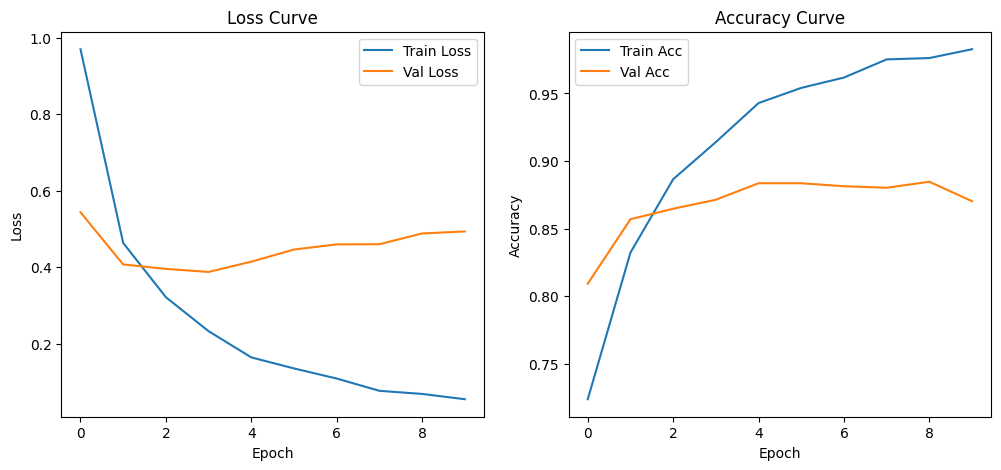


Classification Report:
              precision    recall  f1-score   support

       akiec       0.69      0.76      0.72        33
         bcc       0.93      0.75      0.83        51
         bkl       0.83      0.78      0.80       110
          df       0.83      0.83      0.83        12
         mel       0.69      0.73      0.71       111
          nv       0.94      0.95      0.95       671
        vasc       0.86      0.86      0.86        14

    accuracy                           0.89      1002
   macro avg       0.82      0.81      0.81      1002
weighted avg       0.89      0.89      0.89      1002



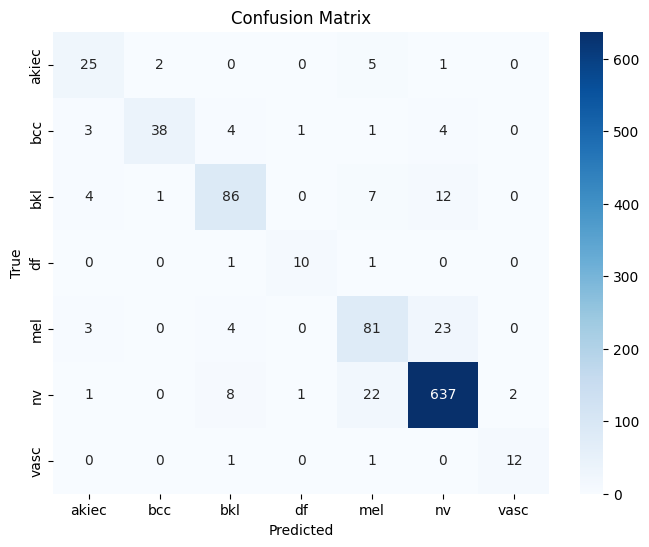

Model saved as efficientnet+meta_03.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # EfficientNet-B0 backbone
        self.cnn = efficientnet_b0(weights='IMAGENET1K_V1')
        in_features = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Identity()

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(22, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalNet(num_classes=len(le_dx.classes_), tabular_input_dim=len(tabular_cols)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

torch.save(model.state_dict(), "efficientnet+meta_03.pth")
print("Model saved as efficientnet+meta_03.pth")

## 4. VGG16

### 4.1 Model ảnh

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:11<00:00, 49.1MB/s] 


Epoch 1/10
----------
val Loss: 1.0352 Acc: 0.6698
Epoch 2/10
----------
train Loss: 1.0580 Acc: 0.6708
val Loss: 1.1531 Acc: 0.6698
Epoch 3/10
----------
train Loss: 1.1477 Acc: 0.6695
val Loss: 1.1331 Acc: 0.6698
Epoch 4/10
----------
train Loss: 1.1447 Acc: 0.6695
val Loss: 1.1409 Acc: 0.6698
Epoch 5/10
----------
train Loss: 1.1421 Acc: 0.6695
val Loss: 1.1305 Acc: 0.6698
Epoch 6/10
----------
train Loss: 1.1417 Acc: 0.6695
val Loss: 1.1334 Acc: 0.6698
Epoch 7/10
----------
train Loss: 1.1381 Acc: 0.6695
val Loss: 1.1344 Acc: 0.6698
Epoch 8/10
----------
train Loss: 1.1357 Acc: 0.6695
val Loss: 1.1298 Acc: 0.6698
Epoch 9/10
----------
train Loss: 1.1337 Acc: 0.6695
val Loss: 1.1298 Acc: 0.6698
Epoch 10/10
----------
train Loss: 1.1353 Acc: 0.6695
val Loss: 1.1297 Acc: 0.6698


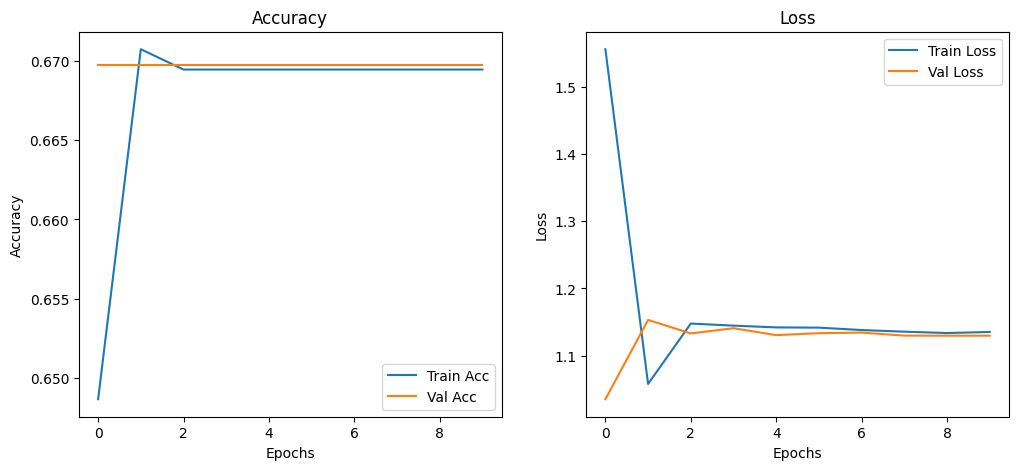


Classification Report:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.00      0.00      0.00       165
          df       0.00      0.00      0.00        17
         mel       0.00      0.00      0.00       167
          nv       0.67      1.00      0.80      1006
        vasc       0.00      0.00      0.00        22

    accuracy                           0.67      1503
   macro avg       0.10      0.14      0.11      1503
weighted avg       0.45      0.67      0.54      1503



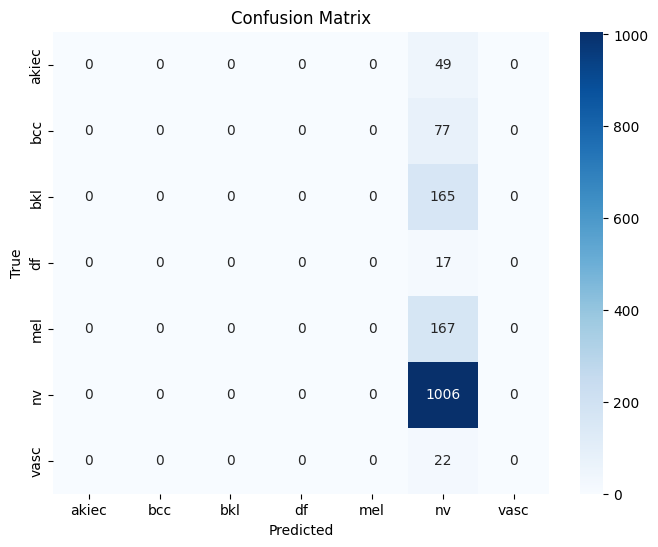

In [ ]:

train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


model = vgg16(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=10)

plot_training_curves(train_acc, val_acc, train_loss, val_loss)


model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)

### 4.2 Model kết hợp cả bảng và ảnh

100%|██████████| 220/220 [01:59<00:00,  1.84it/s]


Epoch [1/10] Train Loss: 0.8745 Train Acc: 0.6991 Val Loss: 0.7473 Val Acc: 0.7237


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [2/10] Train Loss: 0.6575 Train Acc: 0.7558 Val Loss: 0.5954 Val Acc: 0.7770


100%|██████████| 220/220 [01:58<00:00,  1.85it/s]


Epoch [3/10] Train Loss: 0.5815 Train Acc: 0.7837 Val Loss: 0.5886 Val Acc: 0.7696


100%|██████████| 220/220 [01:59<00:00,  1.84it/s]


Epoch [4/10] Train Loss: 0.5628 Train Acc: 0.7880 Val Loss: 0.5770 Val Acc: 0.7736


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [5/10] Train Loss: 0.4904 Train Acc: 0.8164 Val Loss: 0.5520 Val Acc: 0.7969


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [6/10] Train Loss: 0.4547 Train Acc: 0.8325 Val Loss: 0.4724 Val Acc: 0.8329


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [7/10] Train Loss: 0.3833 Train Acc: 0.8558 Val Loss: 0.5583 Val Acc: 0.7816


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [8/10] Train Loss: 0.3446 Train Acc: 0.8750 Val Loss: 0.4981 Val Acc: 0.8209


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [9/10] Train Loss: 0.3048 Train Acc: 0.8867 Val Loss: 0.4086 Val Acc: 0.8628


100%|██████████| 220/220 [01:58<00:00,  1.86it/s]


Epoch [10/10] Train Loss: 0.2611 Train Acc: 0.9033 Val Loss: 0.5772 Val Acc: 0.8362


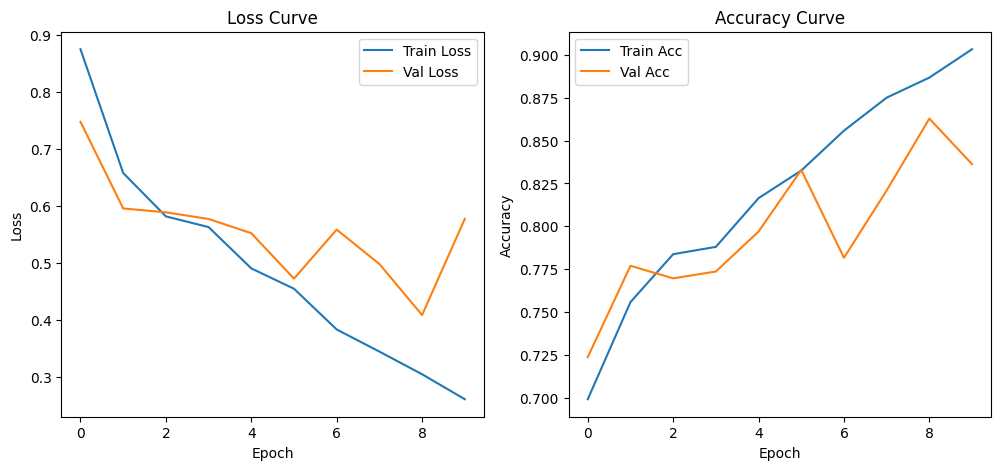


Classification Report:
              precision    recall  f1-score   support

       akiec       0.44      0.57      0.50        49
         bcc       0.83      0.56      0.67        77
         bkl       0.71      0.73      0.72       165
          df       0.64      0.41      0.50        17
         mel       0.74      0.49      0.58       167
          nv       0.90      0.97      0.93      1006
        vasc       1.00      0.32      0.48        22

    accuracy                           0.84      1503
   macro avg       0.75      0.58      0.63      1503
weighted avg       0.84      0.84      0.83      1503



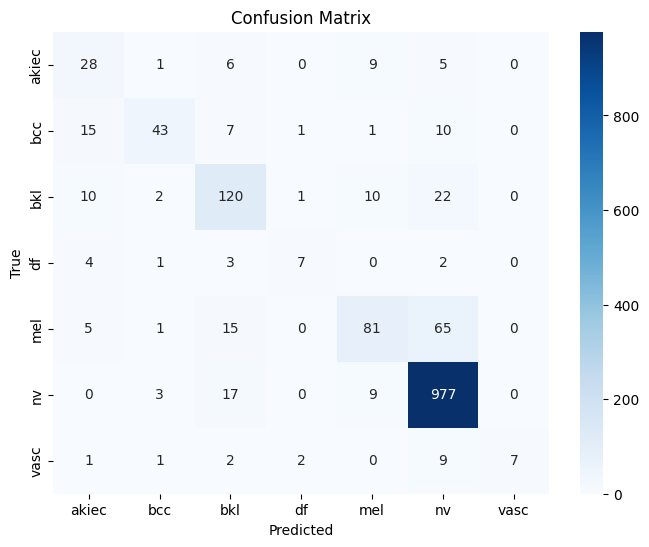

Model saved as vgg+meta_01.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # --- VGG16 backbone ---
        self.cnn = vgg16(weights='IMAGENET1K_V1')
        in_features = self.cnn.classifier[6].in_features
        # Bỏ FC cuối để lấy đặc trưng ảnh
        self.cnn.classifier[6] = nn.Identity()

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)          # (batch_size, in_features)
        tab_feat = self.tabular_fc(tabular) # (batch_size, 128)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_tab_shape = train_dataset[0][1].shape[0]
model = MultiModalNet(
    num_classes=len(le_dx.classes_),
    tabular_input_dim=sample_tab_shape
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)


plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)


model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

torch.save(model.state_dict(), "vgg+meta_01.pth")
print("Model saved as vgg+meta_01.pth")

## 5. DenseNet121

### 5.1 Model ảnh

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 11.8MB/s]


Epoch 1/10
----------
train Loss: 0.7988 Acc: 0.7097
val Loss: 0.7642 Acc: 0.7370
Epoch 2/10
----------
train Loss: 0.6974 Acc: 0.7405
val Loss: 0.7577 Acc: 0.7410
Epoch 3/10
----------
train Loss: 0.6663 Acc: 0.7542
val Loss: 0.6408 Acc: 0.7630
Epoch 4/10
----------
train Loss: 0.6085 Acc: 0.7735
val Loss: 0.6569 Acc: 0.7523
Epoch 5/10
----------
train Loss: 0.5767 Acc: 0.7835
val Loss: 0.5629 Acc: 0.7943
Epoch 6/10
----------
train Loss: 0.5412 Acc: 0.7993
val Loss: 0.5809 Acc: 0.7989
Epoch 7/10
----------
train Loss: 0.5361 Acc: 0.8004
val Loss: 0.5753 Acc: 0.8016
Epoch 8/10
----------
train Loss: 0.4205 Acc: 0.8432
val Loss: 0.4322 Acc: 0.8402
Epoch 9/10
----------
train Loss: 0.3630 Acc: 0.8676
val Loss: 0.4241 Acc: 0.8409
Epoch 10/10
----------
train Loss: 0.3369 Acc: 0.8789
val Loss: 0.4371 Acc: 0.8442


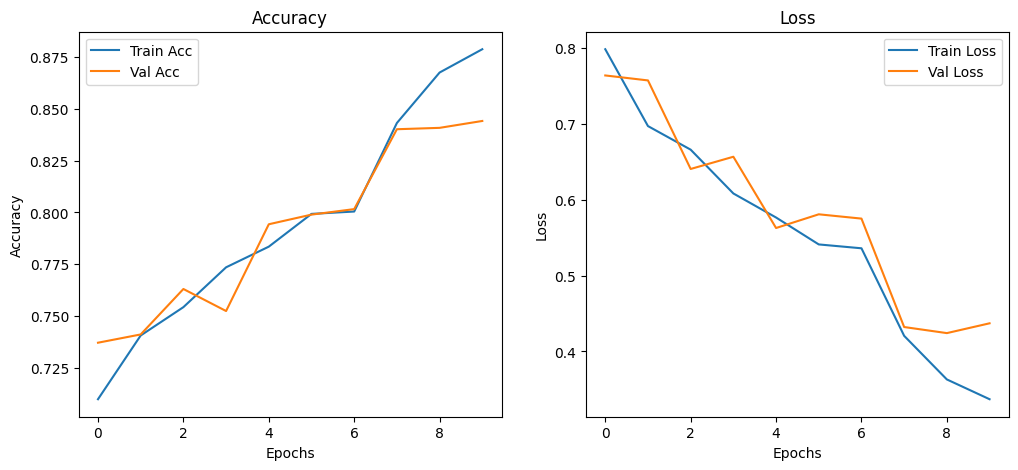


Classification Report:
              precision    recall  f1-score   support

       akiec       0.65      0.61      0.63        49
         bcc       0.68      0.83      0.75        77
         bkl       0.69      0.67      0.68       165
          df       0.64      0.41      0.50        17
         mel       0.69      0.51      0.58       167
          nv       0.91      0.95      0.93      1006
        vasc       0.89      0.77      0.83        22

    accuracy                           0.84      1503
   macro avg       0.74      0.68      0.70      1503
weighted avg       0.84      0.84      0.84      1503



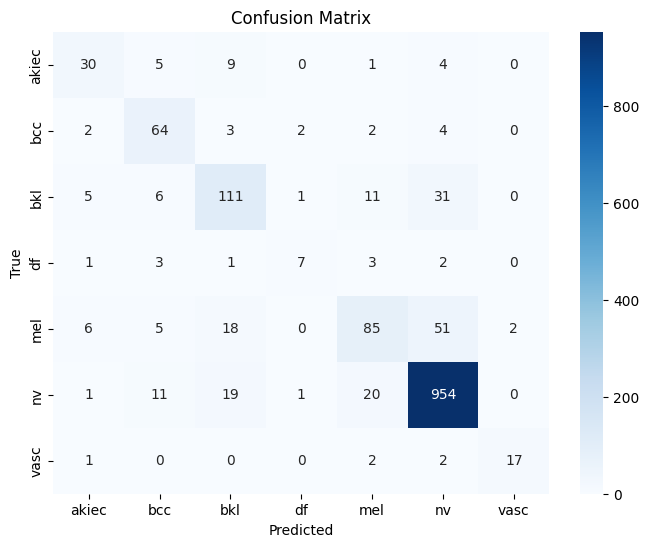

In [ ]:
train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


model = densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=10)


plot_training_curves(train_acc, val_acc, train_loss, val_loss)


model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)

### 5.2 Model kết hợp cả bảng và ảnh

100%|██████████| 254/254 [02:00<00:00,  2.10it/s]


Epoch [1/10] Train Loss: 0.6988 Train Acc: 0.7554 Val Loss: 0.4781 Val Acc: 0.8337


100%|██████████| 254/254 [02:01<00:00,  2.09it/s]


Epoch [2/10] Train Loss: 0.4203 Train Acc: 0.8532 Val Loss: 0.4639 Val Acc: 0.8459


100%|██████████| 254/254 [02:01<00:00,  2.09it/s]


Epoch [3/10] Train Loss: 0.2980 Train Acc: 0.8921 Val Loss: 0.4049 Val Acc: 0.8548


100%|██████████| 254/254 [02:01<00:00,  2.08it/s]


Epoch [4/10] Train Loss: 0.2101 Train Acc: 0.9247 Val Loss: 0.6178 Val Acc: 0.7783


100%|██████████| 254/254 [02:01<00:00,  2.08it/s]


Epoch [5/10] Train Loss: 0.1554 Train Acc: 0.9430 Val Loss: 0.4193 Val Acc: 0.8725


100%|██████████| 254/254 [02:01<00:00,  2.08it/s]


Epoch [6/10] Train Loss: 0.1129 Train Acc: 0.9613 Val Loss: 0.4649 Val Acc: 0.8736


100%|██████████| 254/254 [02:01<00:00,  2.10it/s]


Epoch [7/10] Train Loss: 0.0947 Train Acc: 0.9697 Val Loss: 0.4466 Val Acc: 0.8814


100%|██████████| 254/254 [02:01<00:00,  2.09it/s]


Epoch [8/10] Train Loss: 0.0748 Train Acc: 0.9752 Val Loss: 0.4253 Val Acc: 0.8769


100%|██████████| 254/254 [02:01<00:00,  2.10it/s]


Epoch [9/10] Train Loss: 0.0564 Train Acc: 0.9809 Val Loss: 0.4894 Val Acc: 0.8803


100%|██████████| 254/254 [02:01<00:00,  2.09it/s]


Epoch [10/10] Train Loss: 0.0699 Train Acc: 0.9756 Val Loss: 0.4198 Val Acc: 0.8847


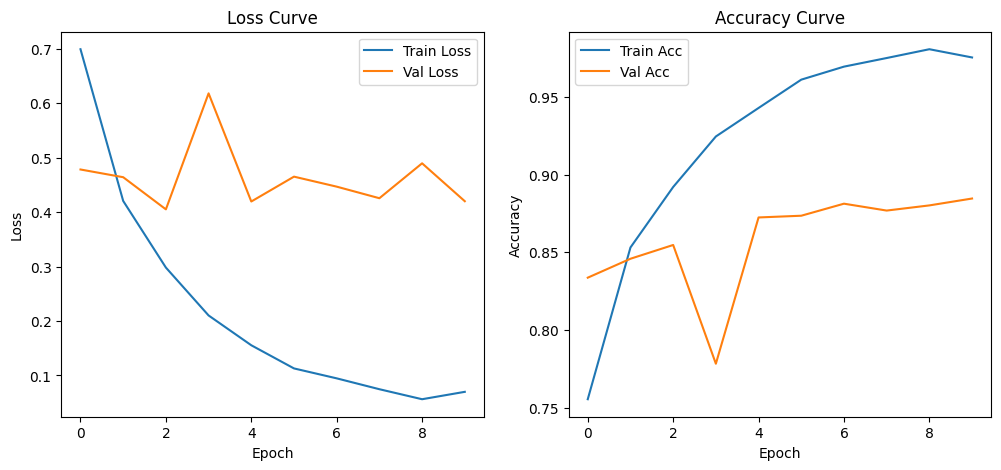


Classification Report:
              precision    recall  f1-score   support

       akiec       0.68      0.79      0.73        33
         bcc       0.91      0.76      0.83        51
         bkl       0.68      0.85      0.75       110
          df       1.00      0.83      0.91        12
         mel       0.72      0.67      0.69       111
          nv       0.96      0.93      0.94       671
        vasc       0.87      0.93      0.90        14

    accuracy                           0.88      1002
   macro avg       0.83      0.82      0.82      1002
weighted avg       0.89      0.88      0.88      1002



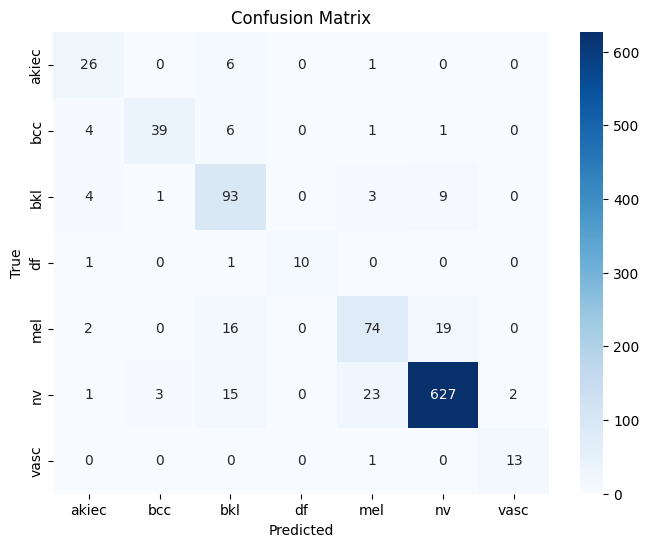

Model saved as mobilenet+meta_01.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

sample_tab_shape = train_dataset[0][1].shape[0]

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # DenseNet121 backbone
        self.cnn = densenet121(pretrained=True)
        in_features = self.cnn.classifier.in_features
        self.cnn.classifier = nn.Identity()  # bỏ classifier gốc

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

model = MultiModalNet(
    num_classes=len(le_dx.classes_),
    tabular_input_dim=sample_tab_shape
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

# ===== 13. Save model =====
torch.save(model.state_dict(), "mobilenet+meta_01.pth")
print("Model saved as mobilenet+meta_01.pth")

## 6. MobileNet_V2

### 6.1 Model ảnh

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 132MB/s]


Epoch 1/10
----------
train Loss: 0.7831 Acc: 0.7160
val Loss: 0.7581 Acc: 0.7563
Epoch 2/10
----------
train Loss: 0.6595 Acc: 0.7605
val Loss: 0.7129 Acc: 0.7477
Epoch 3/10
----------
train Loss: 0.5646 Acc: 0.7924
val Loss: 0.6121 Acc: 0.7790
Epoch 4/10
----------
train Loss: 0.5406 Acc: 0.8020
val Loss: 0.5737 Acc: 0.7943
Epoch 5/10
----------
train Loss: 0.4782 Acc: 0.8203
val Loss: 0.5378 Acc: 0.8043
Epoch 6/10
----------
train Loss: 0.4629 Acc: 0.8278
val Loss: 0.5478 Acc: 0.8136
Epoch 7/10
----------
train Loss: 0.4348 Acc: 0.8424
val Loss: 0.5002 Acc: 0.8149
Epoch 8/10
----------
train Loss: 0.3060 Acc: 0.8909
val Loss: 0.4194 Acc: 0.8495
Epoch 9/10
----------
train Loss: 0.2381 Acc: 0.9130
val Loss: 0.4182 Acc: 0.8569
Epoch 10/10
----------
train Loss: 0.2055 Acc: 0.9244
val Loss: 0.4385 Acc: 0.8509


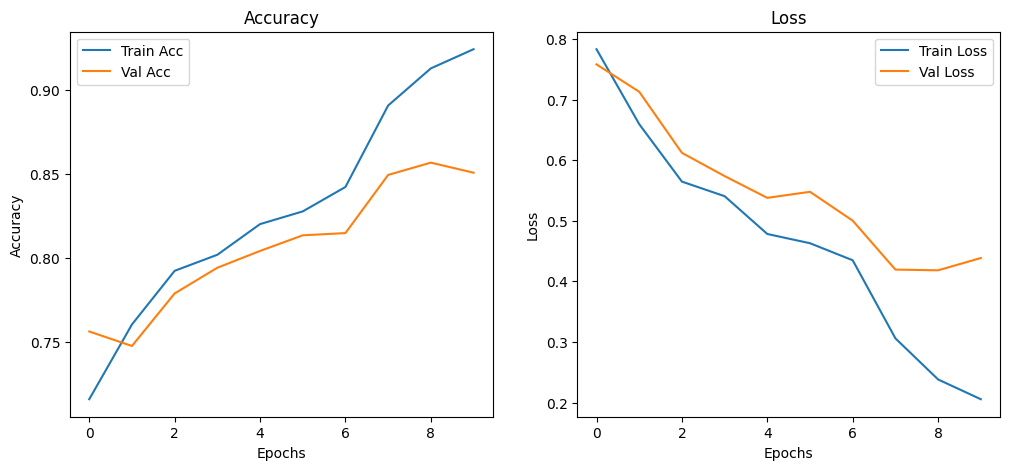


Classification Report:
              precision    recall  f1-score   support

       akiec       0.59      0.61      0.60        49
         bcc       0.78      0.73      0.75        77
         bkl       0.66      0.73      0.69       165
          df       0.78      0.41      0.54        17
         mel       0.64      0.59      0.61       167
          nv       0.93      0.94      0.93      1006
        vasc       1.00      0.73      0.84        22

    accuracy                           0.85      1503
   macro avg       0.77      0.68      0.71      1503
weighted avg       0.85      0.85      0.84      1503



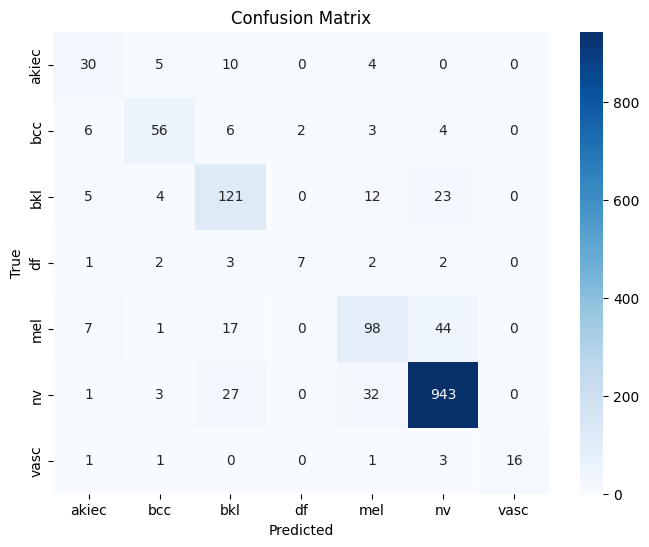

In [ ]:
train_dataset = SkinDataset1(train_df, transform=data_transforms['train'])
val_dataset   = SkinDataset1(val_df, transform=data_transforms['val'])
test_dataset  = SkinDataset1(test_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

model = mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_acc, val_acc, train_loss, val_loss = train_model1(model, criterion, optimizer, scheduler, num_epochs=10)

plot_training_curves(train_acc, val_acc, train_loss, val_loss)


model.load_state_dict(torch.load("best_model.pt"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

plot_confusion_matrix(y_true, y_pred, class_names=train_dataset.classes)


### 6.2 Model kết hợp cả bảng và ảnh

100%|██████████| 254/254 [01:35<00:00,  2.67it/s]


Epoch [1/10] Train Loss: 0.6814 Train Acc: 0.7563 Val Loss: 0.4896 Val Acc: 0.8415


100%|██████████| 254/254 [01:34<00:00,  2.69it/s]


Epoch [2/10] Train Loss: 0.4213 Train Acc: 0.8475 Val Loss: 0.4180 Val Acc: 0.8392


100%|██████████| 254/254 [01:34<00:00,  2.68it/s]


Epoch [3/10] Train Loss: 0.3192 Train Acc: 0.8831 Val Loss: 0.4103 Val Acc: 0.8559


100%|██████████| 254/254 [01:36<00:00,  2.64it/s]


Epoch [4/10] Train Loss: 0.2316 Train Acc: 0.9153 Val Loss: 0.4104 Val Acc: 0.8647


100%|██████████| 254/254 [01:40<00:00,  2.54it/s]


Epoch [5/10] Train Loss: 0.1834 Train Acc: 0.9327 Val Loss: 0.4125 Val Acc: 0.8614


100%|██████████| 254/254 [01:37<00:00,  2.61it/s]


Epoch [6/10] Train Loss: 0.1501 Train Acc: 0.9467 Val Loss: 0.4145 Val Acc: 0.8692


100%|██████████| 254/254 [01:36<00:00,  2.64it/s]


Epoch [7/10] Train Loss: 0.1142 Train Acc: 0.9622 Val Loss: 0.4622 Val Acc: 0.8703


100%|██████████| 254/254 [01:34<00:00,  2.69it/s]


Epoch [8/10] Train Loss: 0.0898 Train Acc: 0.9700 Val Loss: 0.4656 Val Acc: 0.8570


100%|██████████| 254/254 [01:35<00:00,  2.67it/s]


Epoch [9/10] Train Loss: 0.0759 Train Acc: 0.9744 Val Loss: 0.5110 Val Acc: 0.8725


100%|██████████| 254/254 [01:39<00:00,  2.54it/s]


Epoch [10/10] Train Loss: 0.0647 Train Acc: 0.9761 Val Loss: 0.5131 Val Acc: 0.8659


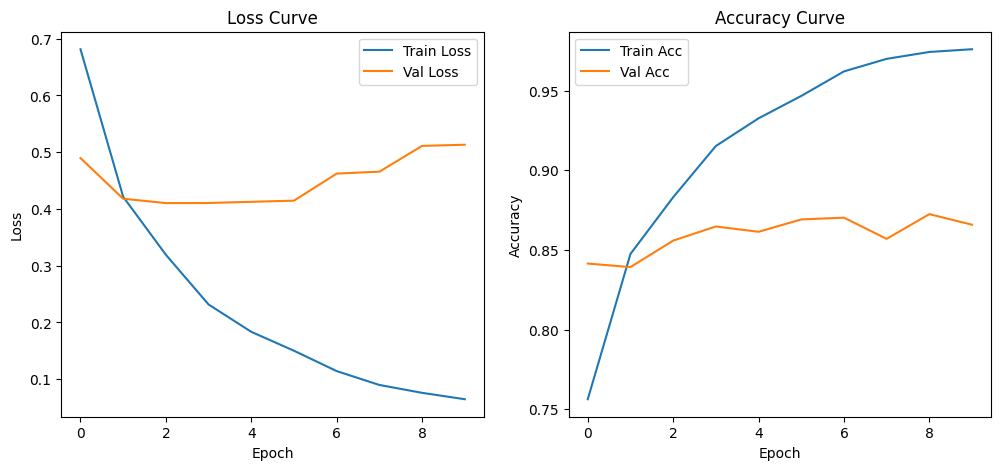


Classification Report:
              precision    recall  f1-score   support

       akiec       0.53      0.88      0.66        33
         bcc       0.80      0.71      0.75        51
         bkl       0.85      0.69      0.76       110
          df       0.90      0.75      0.82        12
         mel       0.68      0.56      0.61       111
          nv       0.93      0.97      0.95       671
        vasc       0.92      0.86      0.89        14

    accuracy                           0.87      1002
   macro avg       0.80      0.77      0.78      1002
weighted avg       0.87      0.87      0.87      1002



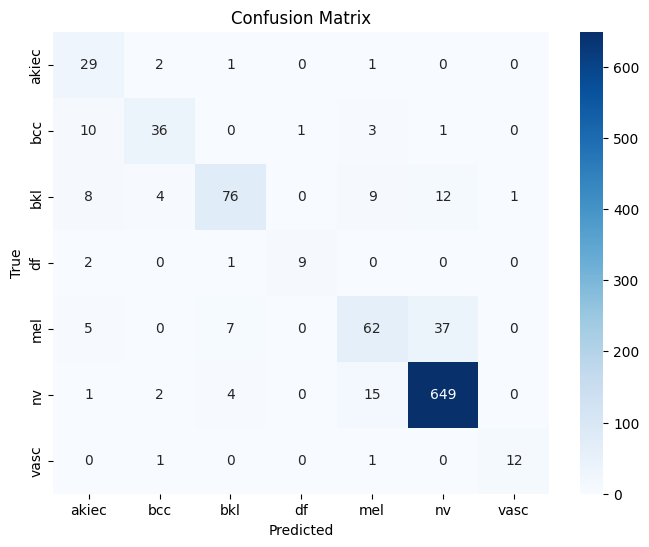

Model saved as mobilenet+meta_01.pth


In [ ]:
train_dataset = SkinDataset2(train_df, transform=data_transforms['train'], tabular_cols=tabular_cols)
val_dataset   = SkinDataset2(val_df, transform=data_transforms['val'], tabular_cols=tabular_cols)
test_dataset  = SkinDataset2(test_df, transform=data_transforms['val'], tabular_cols=tabular_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MultiModalNet(nn.Module):
    def __init__(self, num_classes, tabular_input_dim):
        super(MultiModalNet, self).__init__()
        # MobileNetV2 backbone
        self.cnn = mobilenet_v2(weights='IMAGENET1K_V1')
        in_features = self.cnn.classifier[1].in_features
        self.cnn.classifier = nn.Identity()

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2)
        )

        # Combined head
        self.fc = nn.Sequential(
            nn.Linear(in_features + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        return self.fc(combined)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_tab_shape = train_dataset[0][1].shape[0]
model = MultiModalNet(
    num_classes=len(le_dx.classes_),
    tabular_input_dim=sample_tab_shape
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


history = train_model2(model, train_loader, val_loader, criterion, optimizer, epochs=10)

plot_training_curves(
    history["train_acc"],
    history["val_acc"],
    history["train_loss"],
    history["val_loss"]
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, tabs, labels in test_loader:
        images, tabs, labels = images.to(device), tabs.to(device), labels.to(device)
        outputs = model(images, tabs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le_dx.classes_))

plot_confusion_matrix(y_true, y_pred, class_names=le_dx.classes_)

torch.save(model.state_dict(), "mobilenet+meta_01.pth")
print("Model saved as mobilenet+meta_01.pth")

# IV. Tuning model tốt nhất-EfficientB0

- Sau khi thử nghiệm 6 mô hình (ResNet50, ResNet18, EfficientNet-B0, VGG16, DenseNet121, MobileNetV2) với cùng điều kiện huấn luyện, với cả 2 trường hợp: chỉ có ảnh và có cả ảnh và metadata thì EfficientNet-B0 đều đạt kết quả tốt nhất mà không bị overfitting với Test Accuracy lần luợt là 0.8855 và 0.8703
- Nhóm fine-tune EfficientNet-B0 bằng cách sử dụng pretrained ImageNet, thay đổi classifier, áp dụng data augmentation, class balancing, optimizer, scheduler, gradient clipping, early stopping và metadata fusion.

Epoch 41/50 [Train]:  34%|███▍      | 151/438 [01:40<03:17,  1.45it/s, Loss=0.0299, Batch=151/313]

Batch 151/313, Loss: 0.0299, Acc: 0.9652


Epoch 41/50 [Train]:  46%|████▌     | 201/438 [02:14<02:49,  1.40it/s, Loss=0.0230, Batch=201/313]

Batch 201/313, Loss: 0.0230, Acc: 0.9621


Epoch 41/50 [Train]:  57%|█████▋    | 251/438 [02:47<01:57,  1.59it/s, Loss=0.0517, Batch=251/313]

Batch 251/313, Loss: 0.0517, Acc: 0.9619


Epoch 41/50 [Train]:  69%|██████▊   | 301/438 [03:20<01:30,  1.52it/s, Loss=0.0215, Batch=301/313]

Batch 301/313, Loss: 0.0215, Acc: 0.9620


Epoch 41/50 [Train]:  80%|████████  | 351/438 [03:55<00:58,  1.48it/s, Loss=0.4482, Batch=351/313]

Batch 351/313, Loss: 0.4482, Acc: 0.9606


Epoch 41/50 [Train]:  92%|█████████▏| 401/438 [04:29<00:25,  1.46it/s, Loss=0.0127, Batch=401/313]

Batch 401/313, Loss: 0.0127, Acc: 0.9613


Epoch 41/50 [Val]: 100%|██████████| 94/94 [00:54<00:00,  1.73it/s]


Epoch 41/50:
Train Loss: 0.0894, Train Acc: 0.9613
Val Loss: 0.8934, Val Acc: 0.8888
LR: 1.05e-05
------------------------------------------------------------


Epoch 42/50 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Processing batch 1...


Epoch 42/50 [Train]:   0%|          | 1/438 [00:00<05:40,  1.28it/s, Loss=0.0008, Batch=1/313]

Batch 1/313, Loss: 0.0008, Acc: 1.0000


Epoch 42/50 [Train]:   0%|          | 2/438 [00:01<05:08,  1.41it/s, Loss=0.0032, Batch=2/313]

Processing batch 2...


Epoch 42/50 [Train]:   1%|          | 3/438 [00:02<04:57,  1.46it/s, Loss=0.0023, Batch=3/313]

Processing batch 3...


Epoch 42/50 [Train]:  12%|█▏        | 51/438 [00:33<04:13,  1.52it/s, Loss=1.1863, Batch=51/313]

Batch 51/313, Loss: 1.1863, Acc: 0.9669


Epoch 42/50 [Train]:  23%|██▎       | 101/438 [01:05<03:38,  1.55it/s, Loss=0.0122, Batch=101/313]

Batch 101/313, Loss: 0.0122, Acc: 0.9554


Epoch 42/50 [Train]:  34%|███▍      | 151/438 [01:38<03:07,  1.53it/s, Loss=0.0076, Batch=151/313]

Batch 151/313, Loss: 0.0076, Acc: 0.9578


Epoch 42/50 [Train]:  46%|████▌     | 201/438 [02:11<02:32,  1.56it/s, Loss=0.6618, Batch=201/313]

Batch 201/313, Loss: 0.6618, Acc: 0.9590


Epoch 42/50 [Train]:  57%|█████▋    | 251/438 [02:43<01:58,  1.57it/s, Loss=0.0153, Batch=251/313]

Batch 251/313, Loss: 0.0153, Acc: 0.9599


Epoch 42/50 [Train]:  69%|██████▊   | 301/438 [03:15<01:29,  1.54it/s, Loss=0.0187, Batch=301/313]

Batch 301/313, Loss: 0.0187, Acc: 0.9593


Epoch 42/50 [Train]:  80%|████████  | 351/438 [03:48<00:56,  1.53it/s, Loss=0.0223, Batch=351/313]

Batch 351/313, Loss: 0.0223, Acc: 0.9603


Epoch 42/50 [Train]:  92%|█████████▏| 401/438 [04:21<00:24,  1.54it/s, Loss=0.0623, Batch=401/313]

Batch 401/313, Loss: 0.0623, Acc: 0.9627


Epoch 42/50 [Val]: 100%|██████████| 94/94 [00:55<00:00,  1.70it/s]


Epoch 42/50:
Train Loss: 0.1193, Train Acc: 0.9630
Val Loss: 0.8703, Val Acc: 0.8881
LR: 8.71e-06
------------------------------------------------------------


Epoch 43/50 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Processing batch 1...


Epoch 43/50 [Train]:   0%|          | 1/438 [00:00<05:28,  1.33it/s, Loss=0.0386, Batch=1/313]

Batch 1/313, Loss: 0.0386, Acc: 1.0000


Epoch 43/50 [Train]:   0%|          | 2/438 [00:01<05:17,  1.37it/s, Loss=0.0300, Batch=2/313]

Processing batch 2...


Epoch 43/50 [Train]:   1%|          | 3/438 [00:02<05:10,  1.40it/s, Loss=0.0147, Batch=3/313]

Processing batch 3...


Epoch 43/50 [Train]:  12%|█▏        | 51/438 [00:34<04:40,  1.38it/s, Loss=0.1742, Batch=51/313]

Batch 51/313, Loss: 0.1742, Acc: 0.9706


Epoch 43/50 [Train]:  23%|██▎       | 101/438 [01:06<03:31,  1.59it/s, Loss=0.0910, Batch=101/313]

Batch 101/313, Loss: 0.0910, Acc: 0.9653


Epoch 43/50 [Train]:  34%|███▍      | 151/438 [01:39<03:07,  1.53it/s, Loss=0.0022, Batch=151/313]

Batch 151/313, Loss: 0.0022, Acc: 0.9661


Epoch 43/50 [Train]:  46%|████▌     | 201/438 [02:12<02:41,  1.47it/s, Loss=0.5202, Batch=201/313]

Batch 201/313, Loss: 0.5202, Acc: 0.9639


Epoch 43/50 [Train]:  57%|█████▋    | 251/438 [02:45<02:03,  1.51it/s, Loss=0.0231, Batch=251/313]

Batch 251/313, Loss: 0.0231, Acc: 0.9617


Epoch 43/50 [Train]:  69%|██████▊   | 301/438 [03:17<01:23,  1.65it/s, Loss=0.0184, Batch=301/313]

Batch 301/313, Loss: 0.0184, Acc: 0.9624


Epoch 43/50 [Train]:  80%|████████  | 351/438 [03:48<00:52,  1.64it/s, Loss=0.1571, Batch=351/313]

Batch 351/313, Loss: 0.1571, Acc: 0.9614


Epoch 43/50 [Train]:  92%|█████████▏| 401/438 [04:20<00:23,  1.60it/s, Loss=0.0428, Batch=401/313]

Batch 401/313, Loss: 0.0428, Acc: 0.9609


Epoch 43/50 [Val]: 100%|██████████| 94/94 [00:53<00:00,  1.74it/s]


Epoch 43/50:
Train Loss: 0.1128, Train Acc: 0.9609
Val Loss: 0.9621, Val Acc: 0.8782
LR: 7.12e-06
------------------------------------------------------------


Epoch 44/50 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Processing batch 1...


Epoch 44/50 [Train]:   0%|          | 1/438 [00:00<06:19,  1.15it/s, Loss=0.0172, Batch=1/313]

Batch 1/313, Loss: 0.0172, Acc: 1.0000


Epoch 44/50 [Train]:   0%|          | 2/438 [00:01<05:36,  1.30it/s, Loss=0.2919, Batch=2/313]

Processing batch 2...


Epoch 44/50 [Train]:   1%|          | 3/438 [00:02<05:17,  1.37it/s, Loss=0.0459, Batch=3/313]

Processing batch 3...


Epoch 44/50 [Train]:  12%|█▏        | 51/438 [00:34<04:16,  1.51it/s, Loss=0.0065, Batch=51/313]

Batch 51/313, Loss: 0.0065, Acc: 0.9694


Epoch 44/50 [Train]:  23%|██▎       | 101/438 [01:07<03:39,  1.53it/s, Loss=0.4754, Batch=101/313]

Batch 101/313, Loss: 0.4754, Acc: 0.9623


Epoch 44/50 [Train]:  34%|███▍      | 151/438 [01:41<03:04,  1.56it/s, Loss=0.0100, Batch=151/313]

Batch 151/313, Loss: 0.0100, Acc: 0.9623


Epoch 44/50 [Train]:  46%|████▌     | 201/438 [02:14<02:37,  1.51it/s, Loss=0.8895, Batch=201/313]

Batch 201/313, Loss: 0.8895, Acc: 0.9630


Epoch 44/50 [Train]:  57%|█████▋    | 251/438 [02:47<02:03,  1.51it/s, Loss=0.0252, Batch=251/313]

Batch 251/313, Loss: 0.0252, Acc: 0.9619


Epoch 44/50 [Train]:  69%|██████▊   | 301/438 [03:21<01:37,  1.41it/s, Loss=0.0496, Batch=301/313]

Batch 301/313, Loss: 0.0496, Acc: 0.9624


Epoch 44/50 [Train]:  80%|████████  | 351/438 [03:57<00:59,  1.45it/s, Loss=0.1121, Batch=351/313]

Batch 351/313, Loss: 0.1121, Acc: 0.9628


Epoch 44/50 [Train]:  92%|█████████▏| 401/438 [04:30<00:23,  1.54it/s, Loss=0.0061, Batch=401/313]

Batch 401/313, Loss: 0.0061, Acc: 0.9637


Epoch 44/50 [Val]: 100%|██████████| 94/94 [00:56<00:00,  1.68it/s]


Epoch 44/50:
Train Loss: 0.0973, Train Acc: 0.9629
Val Loss: 0.9067, Val Acc: 0.8862
LR: 5.71e-06
------------------------------------------------------------


Epoch 45/50 [Train]:   0%|          | 1/438 [00:00<05:04,  1.43it/s, Loss=0.0070, Batch=1/313]

Processing batch 1...
Batch 1/313, Loss: 0.0070, Acc: 1.0000
Processing batch 2...


Epoch 45/50 [Train]:   1%|          | 3/438 [00:02<05:20,  1.36it/s, Loss=0.0008, Batch=3/313]

Processing batch 3...


Epoch 45/50 [Train]:  12%|█▏        | 51/438 [00:37<04:44,  1.36it/s, Loss=0.0378, Batch=51/313]

Batch 51/313, Loss: 0.0378, Acc: 0.9681


Epoch 45/50 [Train]:  23%|██▎       | 101/438 [01:11<03:47,  1.48it/s, Loss=0.0546, Batch=101/313]

Batch 101/313, Loss: 0.0546, Acc: 0.9715


Epoch 45/50 [Train]:  34%|███▍      | 151/438 [01:46<03:19,  1.44it/s, Loss=0.0763, Batch=151/313]

Batch 151/313, Loss: 0.0763, Acc: 0.9698


Epoch 45/50 [Train]:  46%|████▌     | 201/438 [02:20<02:47,  1.41it/s, Loss=0.0038, Batch=201/313]

Batch 201/313, Loss: 0.0038, Acc: 0.9701


Epoch 45/50 [Train]:  57%|█████▋    | 251/438 [02:54<02:09,  1.45it/s, Loss=0.0986, Batch=251/313]

Batch 251/313, Loss: 0.0986, Acc: 0.9701


Epoch 45/50 [Train]:  69%|██████▊   | 301/438 [03:28<01:30,  1.51it/s, Loss=0.0014, Batch=301/313]

Batch 301/313, Loss: 0.0014, Acc: 0.9684


Epoch 45/50 [Train]:  80%|████████  | 351/438 [04:03<00:56,  1.54it/s, Loss=0.0597, Batch=351/313]

Batch 351/313, Loss: 0.0597, Acc: 0.9672


Epoch 45/50 [Train]:  92%|█████████▏| 401/438 [04:35<00:23,  1.59it/s, Loss=1.1132, Batch=401/313]

Batch 401/313, Loss: 1.1132, Acc: 0.9660


Epoch 45/50 [Val]: 100%|██████████| 94/94 [00:53<00:00,  1.76it/s]


Epoch 45/50:
Train Loss: 0.0962, Train Acc: 0.9665
Val Loss: 3.6568, Val Acc: 0.8788
LR: 4.48e-06
------------------------------------------------------------


Epoch 46/50 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Processing batch 1...


Epoch 46/50 [Train]:   0%|          | 1/438 [00:00<05:55,  1.23it/s, Loss=0.0059, Batch=1/313]

Batch 1/313, Loss: 0.0059, Acc: 1.0000


Epoch 46/50 [Train]:   0%|          | 2/438 [00:01<05:31,  1.31it/s, Loss=0.0176, Batch=2/313]

Processing batch 2...


Epoch 46/50 [Train]:   1%|          | 3/438 [00:02<05:18,  1.37it/s, Loss=0.0195, Batch=3/313]

Processing batch 3...


Epoch 46/50 [Train]:  12%|█▏        | 51/438 [00:33<03:58,  1.62it/s, Loss=0.0410, Batch=51/313]

Batch 51/313, Loss: 0.0410, Acc: 0.9694


Epoch 46/50 [Train]:  23%|██▎       | 101/438 [01:06<03:36,  1.56it/s, Loss=0.0181, Batch=101/313]

Batch 101/313, Loss: 0.0181, Acc: 0.9703


Epoch 46/50 [Train]:  34%|███▍      | 151/438 [01:38<03:09,  1.52it/s, Loss=1.2081, Batch=151/313]

Batch 151/313, Loss: 1.2081, Acc: 0.9677


Epoch 46/50 [Train]:  46%|████▌     | 201/438 [02:12<02:35,  1.52it/s, Loss=0.0233, Batch=201/313]

Batch 201/313, Loss: 0.0233, Acc: 0.9701


Epoch 46/50 [Train]:  57%|█████▋    | 251/438 [02:46<02:03,  1.51it/s, Loss=0.0473, Batch=251/313]

Batch 251/313, Loss: 0.0473, Acc: 0.9719


Epoch 46/50 [Train]:  69%|██████▊   | 301/438 [03:19<01:31,  1.50it/s, Loss=0.0213, Batch=301/313]

Batch 301/313, Loss: 0.0213, Acc: 0.9720


Epoch 46/50 [Train]:  80%|████████  | 351/438 [03:54<01:01,  1.42it/s, Loss=0.0056, Batch=351/313]

Batch 351/313, Loss: 0.0056, Acc: 0.9712


Epoch 46/50 [Train]:  92%|█████████▏| 401/438 [04:30<00:25,  1.46it/s, Loss=0.0053, Batch=401/313]

Batch 401/313, Loss: 0.0053, Acc: 0.9719


Epoch 46/50 [Val]: 100%|██████████| 94/94 [00:55<00:00,  1.70it/s]


Epoch 46/50:
Train Loss: 0.0793, Train Acc: 0.9717
Val Loss: 0.9933, Val Acc: 0.8868
LR: 3.42e-06
------------------------------------------------------------


Epoch 47/50 [Train]:   0%|          | 0/438 [00:00<?, ?it/s]

Processing batch 1...


Epoch 47/50 [Train]:   0%|          | 1/438 [00:00<05:58,  1.22it/s, Loss=0.0117, Batch=1/313]

Batch 1/313, Loss: 0.0117, Acc: 1.0000


Epoch 47/50 [Train]:   0%|          | 2/438 [00:01<05:35,  1.30it/s, Loss=0.0815, Batch=2/313]

Processing batch 2...


Epoch 47/50 [Train]:   1%|          | 3/438 [00:02<05:16,  1.38it/s, Loss=0.0017, Batch=3/313]

Processing batch 3...


Epoch 47/50 [Train]:  12%|█▏        | 51/438 [00:34<04:07,  1.57it/s, Loss=0.1884, Batch=51/313]

Batch 51/313, Loss: 0.1884, Acc: 0.9706


Epoch 47/50 [Train]:  23%|██▎       | 101/438 [01:06<03:29,  1.61it/s, Loss=0.0171, Batch=101/313]

Batch 101/313, Loss: 0.0171, Acc: 0.9703


Epoch 47/50 [Train]:  34%|███▍      | 151/438 [01:38<03:02,  1.57it/s, Loss=0.0563, Batch=151/313]

Batch 151/313, Loss: 0.0563, Acc: 0.9669


Epoch 47/50 [Train]:  46%|████▌     | 201/438 [02:09<02:30,  1.58it/s, Loss=0.0012, Batch=201/313]

Batch 201/313, Loss: 0.0012, Acc: 0.9674


Epoch 47/50 [Train]:  57%|█████▋    | 251/438 [02:41<02:08,  1.46it/s, Loss=0.0232, Batch=251/313]

Batch 251/313, Loss: 0.0232, Acc: 0.9684


Epoch 47/50 [Train]:  69%|██████▊   | 301/438 [03:15<01:30,  1.51it/s, Loss=0.0085, Batch=301/313]

Batch 301/313, Loss: 0.0085, Acc: 0.9682


Epoch 47/50 [Train]:  80%|████████  | 351/438 [03:50<01:00,  1.43it/s, Loss=0.0215, Batch=351/313]

Batch 351/313, Loss: 0.0215, Acc: 0.9683


Epoch 47/50 [Train]:  92%|█████████▏| 401/438 [04:25<00:24,  1.52it/s, Loss=0.0005, Batch=401/313]

Batch 401/313, Loss: 0.0005, Acc: 0.9687


Epoch 47/50 [Val]: 100%|██████████| 94/94 [00:56<00:00,  1.66it/s]


Epoch 47/50:
Train Loss: 0.1046, Train Acc: 0.9688
Val Loss: 1.0362, Val Acc: 0.8921
LR: 2.56e-06
------------------------------------------------------------
Early stopping triggered after 47 epochs


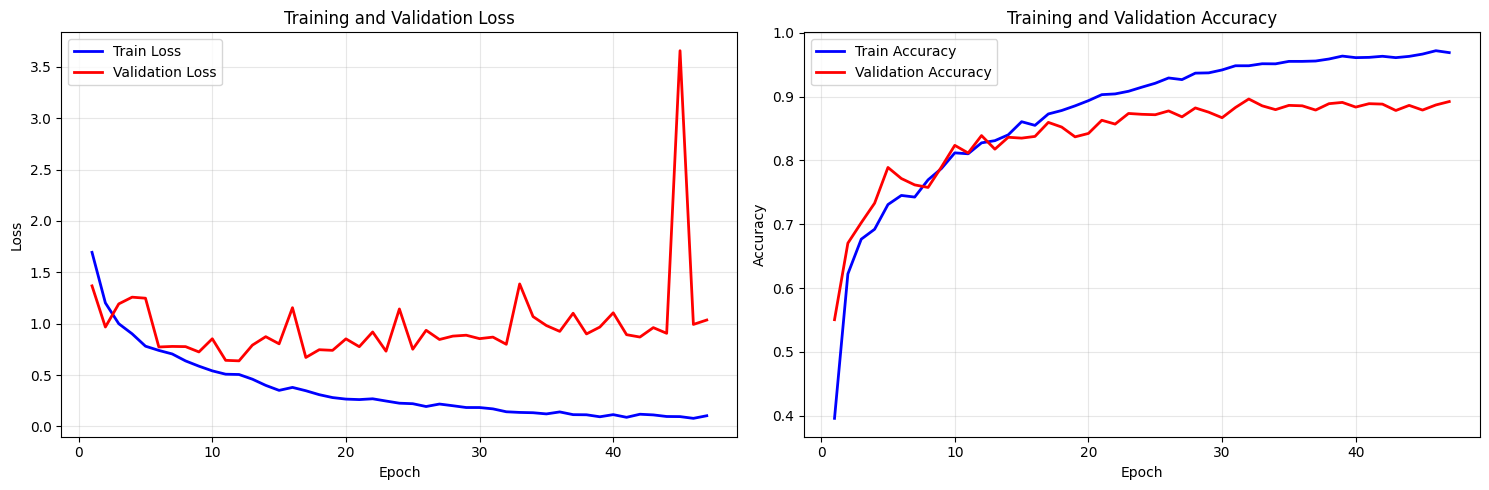


Evaluating on test set...


Evaluating: 100%|██████████| 94/94 [01:34<00:00,  1.01s/it]


Test Accuracy: 0.8762

Detailed Classification Report:
              precision    recall  f1-score   support

       akiec     0.7143    0.5932    0.6481        59
         bcc     0.8353    0.8161    0.8256        87
         bkl     0.7292    0.7500    0.7394       140
          df     1.0000    0.8462    0.9167        13
         mel     0.6645    0.6867    0.6754       150
          nv     0.9420    0.9402    0.9411      1036
        vasc     0.7200    1.0000    0.8372        18

    accuracy                         0.8762      1503
   macro avg     0.8007    0.8046    0.7976      1503
weighted avg     0.8772    0.8762    0.8761      1503



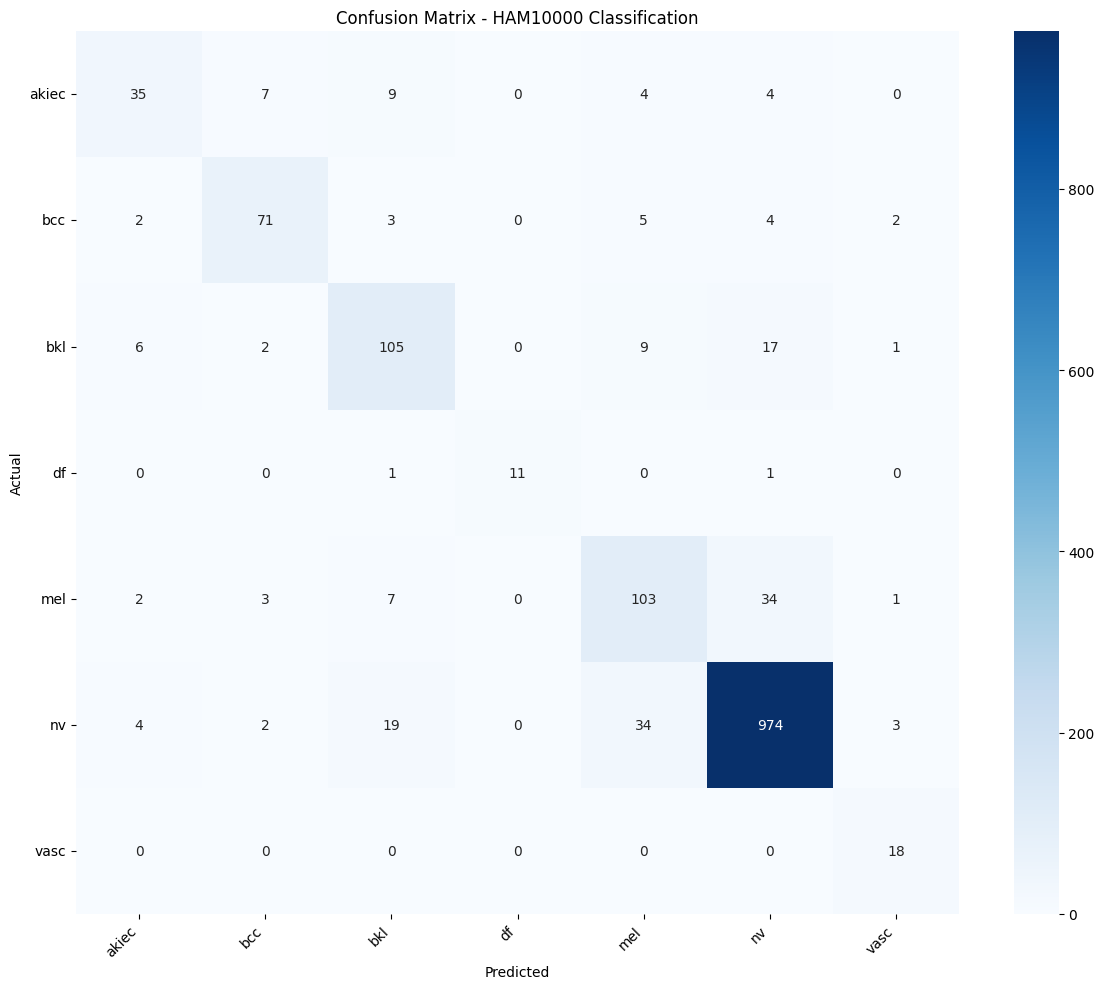


Model saved as 'ham10000_model.pth'
Final test accuracy: 0.8762
akiec: 0.5932 (59 samples)
bcc: 0.8161 (87 samples)
bkl: 0.7500 (140 samples)
df: 0.8462 (13 samples)
mel: 0.6867 (150 samples)
nv: 0.9402 (1036 samples)
vasc: 1.0000 (18 samples)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pandas as pd
import numpy as np
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class HAM10000Dataset(Dataset):    
    def __init__(self, metadata_csv, images_dir_list, transform=None, use_metadata=True):
        self.metadata = pd.read_csv(metadata_csv)
        self.transform = transform
        self.use_metadata = use_metadata
        
        # Create mapping from image_id to full image path
        self.image_paths = {}
        for img_dir in images_dir_list:
            if os.path.exists(img_dir):
                for img_path in glob.glob(os.path.join(img_dir, "*.jpg")):
                    img_id = os.path.basename(img_path).replace('.jpg', '')
                    self.image_paths[img_id] = img_path
        
        # Filter metadata to only include images we have
        self.metadata = self.metadata[self.metadata['image_id'].isin(self.image_paths.keys())].reset_index(drop=True)
        
        # Encode target labels
        self.label_encoder = LabelEncoder()
        self.metadata['encoded_dx'] = self.label_encoder.fit_transform(self.metadata['dx'])
        self.classes = self.label_encoder.classes_
        
        # Process metadata features
        if self.use_metadata:
            self._process_metadata()
        
        print(f"Loaded {len(self.metadata)} samples")
        print(f"Classes: {list(self.classes)}")
        print(f"Class distribution:")
        print(self.metadata['dx'].value_counts())
    
    def _process_metadata(self):
        """Process and encode metadata features"""
        # Age: fill missing with median
        self.metadata['age'].fillna(self.metadata['age'].median(), inplace=True)
        
        # Sex: encode as binary
        sex_encoder = LabelEncoder()
        self.metadata['sex_encoded'] = sex_encoder.fit_transform(self.metadata['sex'].fillna('unknown'))
        
        # Localization: encode anatomical location
        loc_encoder = LabelEncoder()
        self.metadata['localization_encoded'] = loc_encoder.fit_transform(self.metadata['localization'].fillna('unknown'))
        
        # Create feature matrix
        feature_cols = ['age', 'sex_encoded', 'localization_encoded']
        self.metadata_features = self.metadata[feature_cols].values
        
        # Standardize features
        self.scaler = StandardScaler()
        self.metadata_features = self.scaler.fit_transform(self.metadata_features)
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        # Get image info
        row = self.metadata.iloc[idx]
        image_id = row['image_id']
        label = row['encoded_dx']
        
        # Load image
        img_path = self.image_paths[image_id]
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Create black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            print(f"Warning: Could not load image {img_path}")
        
        if self.transform:
            image = self.transform(image)
        
        if self.use_metadata:
            metadata = torch.FloatTensor(self.metadata_features[idx])
            return image, metadata, label
        else:
            return image, label

class MultiModalEfficientNet(nn.Module):
    """EfficientNet with metadata fusion for HAM10000"""
    
    def __init__(self, num_classes, metadata_dim=0, dropout_rate=0.4):
        super(MultiModalEfficientNet, self).__init__()
        
        # Load pretrained EfficientNet-B0
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Remove the final classifier
        backbone_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        self.use_metadata = metadata_dim > 0
        
        if self.use_metadata:
            # Metadata processing branch
            self.metadata_branch = nn.Sequential(
                nn.Linear(metadata_dim, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            )
            
            # Combined classifier
            combined_features = backbone_features + 64
        else:
            combined_features = backbone_features
        
        # Final classifier with more sophisticated architecture
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(combined_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image, metadata=None):
        # Extract image features
        img_features = self.backbone(image)
        
        if self.use_metadata and metadata is not None:
            # Process metadata
            meta_features = self.metadata_branch(metadata)
            # Concatenate features
            combined = torch.cat([img_features, meta_features], dim=1)
        else:
            combined = img_features
        
        # Final classification
        output = self.classifier(combined)
        return output

def get_ham10000_transforms():
    """Data transforms optimized for HAM10000 dermatoscopic images"""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.763, 0.546, 0.570], std=[0.141, 0.152, 0.169])  # HAM10000 stats
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.763, 0.546, 0.570], std=[0.141, 0.152, 0.169])
    ])
    
    return train_transform, val_transform

def create_balanced_sampler(dataset, labels_column='encoded_dx'):
    """Create weighted sampler for balanced training"""
    print("Creating balanced sampler...")
    labels = dataset.metadata[labels_column].values
    class_counts = np.bincount(labels)
    print(f"Class counts: {class_counts}")
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels]
    print("Balanced sampler created successfully")
    
    return torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def train_model(model, train_loader, val_loader, epochs=50, patience=10, train_dataset=None):
    """Enhanced training with class balancing"""
    
    print("Calculating class weights from dataset...")
    # Get class weights directly from the original dataset metadata
    if train_dataset is not None:
        # Get the indices used in train_dataset
        train_indices = train_dataset.indices
        # Get labels for training samples only
        all_labels = train_dataset.dataset.metadata['encoded_dx'].values
        train_labels = all_labels[train_indices]
        
        class_counts = np.bincount(train_labels)
        print(f"Class counts in training set: {class_counts}")
        
        class_weights = 1.0 / class_counts
        class_weights = torch.FloatTensor(class_weights / class_weights.sum() * len(class_weights)).to(device)
        print(f"Class weights: {class_weights}")
    else:
        print("Warning: No train_dataset provided, using equal weights")
        # Fallback to equal weights
        num_classes = len(model.classifier[-1].out_features) if hasattr(model.classifier[-1], 'out_features') else 7
        class_weights = torch.ones(num_classes).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
    
    # Early stopping
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for batch_idx, batch in enumerate(train_pbar):
            # Add debug info for first few batches
            if batch_idx < 3:
                print(f"Processing batch {batch_idx+1}...")
            
            if len(batch) == 3:  # With metadata
                images, metadata, labels = batch
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata)
            else:  # Image only
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Batch': f'{batch_idx+1}/313'})
            
            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                current_acc = train_correct / train_total if train_total > 0 else 0
                print(f"Batch {batch_idx+1}/313, Loss: {loss.item():.4f}, Acc: {current_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for batch in val_pbar:
                if len(batch) == 3:
                    images, metadata, labels = batch
                    images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                    outputs = model(images, metadata)
                else:
                    images, labels = batch
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total
        
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print('-' * 60)
        
        scheduler.step()
        
        # Early stopping based on validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            model.load_state_dict(best_model_state)
            break
    
    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader, class_names):
    """Comprehensive evaluation with per-class metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            if len(batch) == 3:
                images, metadata, labels = batch
                images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
                outputs = model(images, metadata)
            else:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate accuracy
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Classification report
    print('\nDetailed Classification Report:')
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - HAM10000 Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return test_acc, all_preds, all_labels, all_probs

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    
    METADATA_CSV = 'data/HAM10000_metadata.csv'  # Path to metadata file
    IMAGES_DIRS = [
        'data/HAM10000_images_part_1',  # Directory with part 1 images
        'data/HAM10000_images_part_2'   # Directory with part 2 images
    ]
    
    BATCH_SIZE = 16
    EPOCHS = 50
    USE_METADATA = False
    
    # Verify paths exist
    if not os.path.exists(METADATA_CSV):
        raise FileNotFoundError(f"Metadata CSV not found: {METADATA_CSV}")
    
    existing_dirs = [d for d in IMAGES_DIRS if os.path.exists(d)]
    if not existing_dirs:
        raise FileNotFoundError(f"No image directories found: {IMAGES_DIRS}")
    
    print(f"Using image directories: {existing_dirs}")
    
    # Get transforms
    train_transform, val_transform = get_ham10000_transforms()
    
    # Create full dataset
    full_dataset = HAM10000Dataset(
        metadata_csv=METADATA_CSV,
        images_dir_list=existing_dirs,
        transform=train_transform,
        use_metadata=USE_METADATA
    )
    
    # Split dataset (stratified by class)
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    # Use stratified split to maintain class balance
    train_dataset, temp_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, len(full_dataset) - train_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    val_dataset, test_dataset = torch.utils.data.random_split(
        temp_dataset, [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
    
    # Create data loaders - DISABLE balanced sampler temporarily
    print("Creating data loaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Use simple shuffle instead of weighted sampler
        num_workers=0,  # Disable multiprocessing
        pin_memory=False,
        drop_last=True  # Drop incomplete batches
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,
        pin_memory=False
    )
    
    print("Data loaders created successfully")
    
    # Create model
    metadata_dim = 3 if USE_METADATA else 0  # age, sex, localization
    model = MultiModalEfficientNet(
        num_classes=len(full_dataset.classes),
        metadata_dim=metadata_dim,
        dropout_rate=0.4
    ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nModel Summary:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Using metadata: {USE_METADATA}")
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, epochs=EPOCHS, patience=15, train_dataset=train_dataset
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_acc, predictions, labels, probabilities = evaluate_model(
        model, test_loader, full_dataset.classes
    )
    
    # Save model and results
    torch.save({
        'model_state_dict': model.state_dict(),
        'classes': full_dataset.classes,
        'test_accuracy': test_acc,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs
        }
    }, 'ham10000_model.pth')
    
    print(f"\nModel saved as 'ham10000_model.pth'")
    print(f"Final test accuracy: {test_acc:.4f}")
    
    # Print class-wise accuracy
    unique_labels = np.unique(labels)
    for i, class_name in enumerate(full_dataset.classes):
        if i in unique_labels:
            class_mask = np.array(labels) == i
            class_acc = np.mean(np.array(predictions)[class_mask] == np.array(labels)[class_mask])
            class_count = np.sum(class_mask)
            print(f"{class_name}: {class_acc:.4f} ({class_count} samples)")

if __name__ == "__main__":
    main()

# V. Kết luận

| Model          | Input            | Train Loss | Train Acc | Val Loss | Val Acc | Test Acc|
|----------------|------------------|------------|-----------|----------|---------|---------|
| ResNet50       | Chỉ ảnh          | 0.5457     | 0.8009    | 0.6031   | 0.7763  |0.79|
|                | Ảnh + metadata   | 0.1008     | 0.9645    | 0.6581   | 0.8362  |0.84|
| ResNet18       | Chỉ ảnh          | 0.3207     | 0.8813    | 0.4720   | 0.8242  |0.83|
|                | Ảnh + metadata   | 0.0591     | 0.9807    | 0.5634   | 0.8602  |0.84|
| EfficientNetB0 | Chỉ ảnh          | 0.0141     | 0.9961    | 0.4799   | 0.8855  |**0.89**|
|                | Ảnh + metadata   | 0.0550     | 0.9827    | 0.4936   | 0.8703  |**0.89**|
| VGG16          | Chỉ ảnh          | 1.1353     | 0.6695    | 1.1297   | 0.6698  |0.67|
|                | Ảnh + metadata   | 0.2611     | 0.9033    | 0.5772   | 0.8362  |0.84|
| DenseNet121    | Chỉ ảnh          | 0.3369     | 0.8789    | 0.4371   | 0.8442  |0.84|
|                | Ảnh + metadata   | 0.0699     | 0.9756    | 0.4198   | 0.8847  |0.88|
| MobileNetV2    | Chỉ ảnh          | 0.2055     | 0.9244    | 0.4385   | 0.8509  |0.85|
|                | Ảnh + metadata   | 0.0647     | 0.9761    | 0.5131   | 0.8659  |0.87|


### Nhận xét bảng kết quả 6 models:
- ResNet50: Với chỉ ảnh, mô hình học ổn định, chênh lệch train–val nhỏ (~0.02), accuracy tối đa ~0.78, macro F1 thấp (0.54) do dự đoán kém ở lớp hiếm. Kết hợp metadata, accuracy tăng 0.84, macro F1 ~0.68, cải thiện rõ ở lớp hiếm (akiec recall 0.84, df 0.53) nhưng overfitting mạnh và giảm tổng quát hóa.
- ResNet18: Chỉ ảnh đạt ~0.88 train, ~0.82 val, macro F1 = 0.68; lớp hiếm recall thấp. Thêm metadata, train ~0.98, val ~0.86, macro F1 = 0.70, cải thiện ở bkl và akiec. Nên dùng cả ảnh và metadata.
- EfficientNet-B0: Chỉ ảnh đạt ~1.0 train, ~0.886 val, macro F1 = 0.80, ổn định, ít overfit. Kết hợp metadata, train ~0.983, val ~0.87, macro F1 ~0.81, cải thiện nhẹ ở lớp nhỏ nhưng không vượt trội.
- VGG16: Với chỉ ảnh, accuracy rất thấp (~66.95%), underfitting nặng, chủ yếu dự đoán nv. Kết hợp metadata, train ~90.3%, val ~83.6%, phân loại cân bằng hơn, F1 cải thiện rõ. Metadata giúp mô hình học tốt hơn nhiều.
- DenseNet121: Chỉ ảnh học tốt, overfitting nhẹ sau epoch 7–8, accuracy ~0.84, macro F1 ~0.70. Kết hợp metadata, train ~0.98, val ~0.88, macro F1 ~0.82, recall các lớp khó (df, akiec) tăng mạnh nhưng overfitting nặng.
- MobileNet: Với chỉ ảnh, train 92.4%, val 85.1%, macro F1 = 0.71, khá cân bằng, overfit nhẹ. Thêm metadata, train 97.6%, val 86.6%, macro F1 = 0.78, cải thiện rõ ở lớp hiếm (akiec, df), nhưng dễ overfit hơn.


### Qua quá trình thực nghiệm và đánh giá trên sáu mô hình CNN khác nhau cùng, fine-tuning mô hình tốt nhất, có thể rút ra một số điểm như sau:

1. So sánh các mô hình gốc

- Các mô hình hiện đại và gọn nhẹ như EfficientNet-B0, DenseNet121 và MobileNetV2 cho kết quả tốt nhất với độ chính xác và macro F1 cao, đặc biệt khi kết hợp thêm metadata.

- ResNet18 cũng cho hiệu năng ổn định và hưởng lợi rõ khi thêm metadata.

- ResNet50 và đặc biệt VGG16 bộc lộ hạn chế: ResNet50 dễ overfit khi thêm metadata, còn VGG16 underfit nặng nếu chỉ dùng ảnh. Metadata tỏ ra đặc biệt hữu ích để cải thiện cân bằng phân loại cho các lớp hiếm.

- Nhìn chung, metadata đóng vai trò quan trọng giúp nâng cao khả năng nhận diện các lớp khó, dù đi kèm rủi ro overfitting.

2. Ảnh hưởng của Fine-tuning

- Fine-tuning giúp tăng độ chính xác tổng thể lên gần 89% trên tập validation và 87.6% trên tập test.

- Các lớp hiếm như df và vasc cải thiện rõ rệt, chứng tỏ fine-tuning giúp mô hình khai thác tốt hơn dữ liệu phụ trợ.

- Tuy nhiên, một số lớp chính như akiec, bkl, mel lại suy giảm về precision/recall, làm macro recall giảm nhẹ. Điều này cho thấy fine-tuning cần đi kèm các chiến lược tối ưu khác (ví dụ: re-sampling, loss function cân bằng) để duy trì hiệu năng đồng đều trên mọi lớp.

3. Bài học rút ra

- Việc kết hợp lý thuyết deep learning (kiến trúc mạng, backpropagation, fine-tuning) với thực hành (tiền xử lý ảnh, augmentation, huấn luyện, đánh giá) giúp củng cố kiến thức một cách toàn diện.

- Metadata và các kỹ thuật tăng cường dữ liệu đóng vai trò then chốt trong việc giảm overfitting và cải thiện hiệu năng trên các lớp ít mẫu.

- Triển khai mô hình thành ứng dụng web cho thấy tiềm năng ứng dụng thực tế của deep learning trong hỗ trợ y tế.

- Cuối cùng, dự án nhấn mạnh tầm quan trọng của việc lựa chọn mô hình phù hợp, theo dõi kỹ hiện tượng overfitting/underfitting và áp dụng fine-tuning đúng cách để đạt được kết quả tối ưu.

# VI. Phụ lục

### Dataset
- HAM10000 (Skin Cancer MNIST) – [Kaggle](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

### Các mô hình được sử dụng
- ResNet50  
- ResNet18  
- EfficientNetB0  
- VGG16  
- DenseNet121  
- MobileNetV2  

### Thư viện & Link tài liệu
- numpy – https://numpy.org/  
- pandas – https://pandas.pydata.org/  
- scipy – https://scipy.org/  
- matplotlib – https://matplotlib.org/  
- seaborn – https://seaborn.pydata.org/  
- Pillow (PIL) – https://pillow.readthedocs.io/  
- imagehash – https://pypi.org/project/ImageHash/  
- scikit-learn – https://scikit-learn.org/stable/  
- tqdm – https://tqdm.github.io/  
- Keras – https://keras.io/  
- TensorFlow – https://www.tensorflow.org/  
- PyTorch – https://pytorch.org/  
- torchvision – https://pytorch.org/vision/stable/index.html  
- efficientnet-pytorch – https://github.com/lukemelas/EfficientNet-PyTorch  
- Python Standard Library:  
  - os – https://docs.python.org/3/library/os.html  
  - glob – https://docs.python.org/3/library/glob.html  
  - collections – https://docs.python.org/3/library/collections.html  
  - warnings – https://docs.python.org/3/library/warnings.html  
